# **Projeto de Introdução à Ciência dos Dados**
Grupo:
- Luan Eustáquio
- Pedro Basílio

## **Definição do Problema e Objetivos**
Objetivo Geral:

*   Analisar as partidas do Campeonato Brasileiro de Futebol de 2003 a 2023 para entender os fatores que influenciam os resultados dos jogos e o desempenho dos times.

## **1. Preparação do Ambiente:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## **2. Carregamento do Conjuto de Dados:**

In [ ]:
# URLs dos arquivos CSV no GitHub
url_full = 'https://raw.githubusercontent.com/adaoduque/Brasileirao_Dataset/master/campeonato-brasileiro-full.csv'
url_estatisticas = 'https://raw.githubusercontent.com/adaoduque/Brasileirao_Dataset/master/campeonato-brasileiro-estatisticas-full.csv'

# Carregar os dados para DataFrames do pandas
df_full = pd.read_csv(url_full)
df_estatisticas = pd.read_csv(url_estatisticas)

In [ ]:
df_full.head()

,ID,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado
0,1,1,29/03/2003,16:00,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ
1,2,1,29/03/2003,16:00,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS
2,3,1,30/03/2003,16:00,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR
3,4,1,30/03/2003,16:00,Goias,Paysandu,NaN,NaN,NaN,NaN,-,Serra Dourada,2,2,GO,PA
4,5,1,30/03/2003,16:00,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,Beira Rio,1,1,RS,SP


In [ ]:
df_estatisticas.head()

,partida_id,rodata,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Coritiba,0,0,NaN,0,NaN,0,0,0,0,0


## **3. Pré-processamento dos Dados:**

### **Verificando os tipos de dados:**

In [ ]:
df_full.dtypes

ID                     int64
rodata                 int64
data                  object
hora                  object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_Placar        int64
visitante_Placar       int64
mandante_Estado       object
visitante_Estado      object
dtype: object

In [ ]:
df_estatisticas.dtypes

partida_id          int64
rodata              int64
clube              object
chutes              int64
chutes_no_alvo      int64
posse_de_bola      object
passes              int64
precisao_passes    object
faltas              int64
cartao_amarelo      int64
cartao_vermelho     int64
impedimentos        int64
escanteios          int64
dtype: object

As colunas com nomes inadequados ou inconsistentes precisam ser renomeadas para garantir clareza e padronização. Por exemplo, `rodata` e `mandante_Placar`.

In [ ]:
df_full.rename(columns={'rodata': 'rodada', 'hora': 'horario', 'mandante_Placar': 'mandante_placar', 'visitante_Placar': 'visitante_placar', 'mandante_Estado': 'mandante_estado', 'visitante_Estado': 'visitante_estado'}, inplace=True)

df_estatisticas.rename(columns={'rodata': 'rodada', 'partida_id': 'ID', 'chutes_no_alvo': 'chutes_a_gol', 'precisao_passes': 'precisao_dos_passes'}, inplace=True)

A coluna `data` precisa ser convertida para o tipo `datetime` para permitir operações temporais. Em seguida, precisamos extrair apenas o ano desta coluna, criando a coluna ano, já que cada campeonato é realizado anualmente e isso facilita a segmentação dos dados por temporada.

E as colunas como `posse_de_bola` e `precisao_passes`, originalmente armazenadas como strings com símbolos de porcentagem, precisam ser convertidas para valores numéricos para possibilitar cálculos e análises quantitativas.

In [ ]:
# Converter colunas de data
df_full['data'] = pd.to_datetime(df_full['data'], format= '%d/%m/%Y', errors='coerce')
df_full['ano'] = df_full['data'].dt.year

# Converter colunas de percentual para numérico
df_estatisticas['posse_de_bola'] = df_estatisticas['posse_de_bola'].str.rstrip('%').astype('float') / 100.0
df_estatisticas['precisao_dos_passes'] = df_estatisticas['precisao_dos_passes'].str.rstrip('%').astype('float') / 100.0

Removeremos a coluna `hora` porque o horário exato dos jogos não é relevante para a análise proposta, que se concentra em aspectos agregados e estatísticos das partidas ao longo dos anos.

In [ ]:
df_full.drop(columns=['data', 'horario'], inplace=True)

As colunas com valores repetitivos e categóricos, como `mandante`, `visitante`, `formacao_mandante`, entre outras, foram convertidas para o tipo `category`. Isso otimiza o uso de memória e melhora a eficiência de operações futuras, como filtragens e agrupamentos.

In [ ]:
categorical_columns_full = ['mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'tecnico_mandante', 'tecnico_visitante', 'vencedor', 'arena', 'mandante_estado', 'visitante_estado']
for col in categorical_columns_full:
    df_full[col] = df_full[col].astype('category')

categorical_columns_estatisticas = ['clube']
for col in categorical_columns_estatisticas:
    df_estatisticas[col] = df_estatisticas[col].astype('category')

Agora podemos ver os tecnicos, as formações, as arenas e os times que fizeram parte do campeonato brasileiro

In [ ]:
df_full['tecnico_mandante'].cat.categories

Index(['A. Alves da Silva Neto', 'A. Bacchi', 'A. Batista', 'A. C. Pracidelli',
       'A. Cardoso de Oliveira', 'A. Cecílio Sobrinho', 'A. César',
       'A. Evangelista Macedo Freitas', 'A. Faganello', 'A. Felix Teixeira',
       ...
       'V. Eutrópio', 'V. Luxemburgo da Silva', 'V. Severino',
       'V. de Morais Filho', 'V. de Oliveira Lopes Pereira',
       'W. Araujo de Souza', 'W. B. de Almeida', 'W. Carvalho', 'W. Lopes',
       'W. O. de Carvalho'],
      dtype='object', length=214)

In [ ]:
df_full['formacao_mandante'].cat.categories

Index(['3-1-4-2', '3-2-4-1', '3-4-1-2', '3-4-2-1', '3-4-3', '3-5-1-1', '3-5-2',
       '4-1-2-1-2', '4-1-3-2', '4-1-4-1', '4-2-2-2', '4-2-3-1', '4-2-4-0',
       '4-3-1-2', '4-3-2-1', '4-3-3', '4-4-1-1', '4-4-2', '4-5-1', '5-3-2',
       '5-4-1'],
      dtype='object')

In [ ]:
df_full['arena'].cat.categories

Index(['Adelmar da Costa Carvalho', 'Aflitos', 'Allianz Parque',
       'Antônio Guimarães', 'Arena BRB Mané Garrincha', 'Arena Barueri',
       'Arena Castelão', 'Arena Condá', 'Arena Joinville', 'Arena MRV',
       ...
       ' Moisés Lucarelli', ' Morumbi', ' Olímpico', ' Orlando Scarpelli',
       ' Pacaembu', ' Pinheirão', ' Presidente Vargas', ' Serra Dourada',
       ' São Januário', ' Vila Belmiro'],
      dtype='object', length=162)

In [ ]:
df_estatisticas['clube'].cat.categories

Index(['America-MG', 'America-RN', 'Athletico-PR', 'Atletico-GO',
       'Atletico-MG', 'Avai', 'Bahia', 'Barueri', 'Botafogo-RJ', 'Bragantino',
       'Brasiliense', 'CSA', 'Ceara', 'Chapecoense', 'Corinthians', 'Coritiba',
       'Criciuma', 'Cruzeiro', 'Cuiaba', 'Figueirense', 'Flamengo',
       'Fluminense', 'Fortaleza', 'Goias', 'Gremio', 'Gremio Prudente',
       'Guarani', 'Internacional', 'Ipatinga', 'Joinville', 'Juventude',
       'Nautico', 'Palmeiras', 'Parana', 'Paysandu', 'Ponte Preta',
       'Portuguesa', 'Santa Cruz', 'Santo Andre', 'Santos', 'Sao Caetano',
       'Sao Paulo', 'Sport', 'Vasco', 'Vitoria'],
      dtype='object')

Agora, vamos verificar novamente para garantir que todas as conversões foram realizadas corretamente

In [ ]:
df_full.tail()

,ID,rodada,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,ano
8400,8401,38,Bahia,Atletico-MG,3-4-2-1,4-4-2,R. Ceni,L. Scolari,Bahia,Itaipava Arena Fonte Nova,4,1,BA,MG,2023
8401,8402,38,Cuiaba,Athletico-PR,5-3-2,3-4-3,A. Cardoso de Oliveira,W. Carvalho,Cuiaba,Arena Pantanal,3,0,MT,PR,2023
8402,8403,38,Santos,Fortaleza,3-4-1-2,4-2-3-1,M. Fernandes,J. Vojvoda,Fortaleza,Estádio Urbano Caldeira,1,2,SP,CE,2023
8403,8404,38,Sao Paulo,Flamengo,4-2-3-1,4-2-3-1,D. Silvestre Júnior,A. Bacchi,Sao Paulo,Morumbi,1,0,SP,RJ,2023
8404,8405,38,Vasco,Bragantino,4-4-2,4-3-3,R. Díaz,P. Faria Caixinha,Vasco,Estádio São Januário,2,1,RJ,SP,2023


In [ ]:
df_full.dtypes

ID                       int64
rodada                   int64
mandante              category
visitante             category
formacao_mandante     category
formacao_visitante    category
tecnico_mandante      category
tecnico_visitante     category
vencedor              category
arena                 category
mandante_placar          int64
visitante_placar         int64
mandante_estado       category
visitante_estado      category
ano                      int32
dtype: object

In [ ]:
df_estatisticas.tail()

,ID,rodada,clube,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
16805,8403,38,Santos,15,6,0.55,353,0.77,15,2,0,4,10
16806,8404,38,Sao Paulo,9,3,0.42,406,0.84,13,0,0,2,4
16807,8404,38,Flamengo,10,2,0.58,535,0.89,16,3,0,0,9
16808,8405,38,Vasco,13,6,0.45,321,0.78,8,3,0,0,2
16809,8405,38,Bragantino,9,2,0.55,398,0.80,14,1,1,1,3


In [ ]:
df_estatisticas.dtypes

ID                        int64
rodada                    int64
clube                  category
chutes                    int64
chutes_a_gol              int64
posse_de_bola           float64
passes                    int64
precisao_dos_passes     float64
faltas                    int64
cartao_amarelo            int64
cartao_vermelho           int64
impedimentos              int64
escanteios                int64
dtype: object

### **Criação de uma unica tabela:**

A partir das informações presentes na tabela de resultados(`df_full`), gostaríamos de adicionar as seguintes informações na nossa tabela de estatísticas(`df_estatisticas`): <br>


*   Ano: indica o ano em que a partida aconteceu
*   Gols: numero de gols que o time fez naquela partida
*   Resultado: indica se o time ganhou(3), empatou(1) ou perdeu(0) naquela partida (os números de cada resultado estão relacionados a quantidade de pontos que os times ganham na tabela do campeonato)
*   Mandante: coluna binaria que indica se o time foi mandante (1) ou visitante (0)

In [ ]:
df_full.shape[0]

8405

In [ ]:
df_estatisticas.shape[0]

16810

Dado as informações das tabelas e dos tamanhos delas podemos perceber que cada partida da tabela de resultado está relacionada com duas linhas da tabela estatistica, que se refere aos dados de cada time que jogou aquela partida. Assim podemos juntar as tabelas pelo ID respectivo de sua partida.

In [ ]:
# Passo 1: Merge dos dataframes baseado na coluna ID
df_full_estatisticas = pd.merge(df_estatisticas, df_full, on='ID')
df_full_estatisticas.head()

,ID,rodada_x,clube,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,...,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,ano
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,...,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ,2003
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,...,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ,2003
2,2,1,Gremio,0,0,NaN,0,NaN,0,0,...,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS,2003
3,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,...,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS,2003
4,3,1,Coritiba,0,0,NaN,0,NaN,0,0,...,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR,2003


In [ ]:
df_full_estatisticas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   16810 non-null  int64   
 1   rodada_x             16810 non-null  int64   
 2   clube                16810 non-null  category
 3   chutes               16810 non-null  int64   
 4   chutes_a_gol         16810 non-null  int64   
 5   posse_de_bola        6820 non-null   float64 
 6   passes               16810 non-null  int64   
 7   precisao_dos_passes  4512 non-null   float64 
 8   faltas               16810 non-null  int64   
 9   cartao_amarelo       16810 non-null  int64   
 10  cartao_vermelho      16810 non-null  int64   
 11  impedimentos         16810 non-null  int64   
 12  escanteios           16810 non-null  int64   
 13  rodada_y             16810 non-null  int64   
 14  mandante             16810 non-null  category
 15  visitante          

In [ ]:
# Passo 2: Criar as novas colunas no df_estatisticas
df_estatisticas['gols_marcados'] = df_full_estatisticas .apply(
    lambda row: row['mandante_placar'] if row['clube'] == row['mandante'] else row['visitante_placar'], axis=1
)
df_estatisticas['gols_recebidos'] = df_full_estatisticas .apply(
    lambda row: row['mandante_placar'] if row['clube'] != row['mandante'] else row['visitante_placar'], axis=1
)
df_estatisticas['mandante'] = df_full_estatisticas .apply(
    lambda row: 1 if row['clube'] == row['mandante'] else 0, axis=1
)
df_estatisticas['vencedor'] = df_full_estatisticas .apply(
    lambda row: 3 if (row['clube'] == row['mandante'] and row['mandante_placar'] > row['visitante_placar']) or
                 (row['clube'] == row['visitante'] and row['visitante_placar'] > row['mandante_placar']) else
                 (1 if row['mandante_placar'] == row['visitante_placar'] else 0), axis=1
)
df_estatisticas['ano'] = df_full_estatisticas ['ano']


In [ ]:
# Definir a ordem desejada das colunas
nova_ordem = [
    'ID', 'ano', 'rodada', 'clube', 'vencedor', 'gols_marcados', 'gols_recebidos', 'chutes',
    'chutes_a_gol', 'posse_de_bola', 'passes', 'precisao_dos_passes', 'faltas',
    'cartao_amarelo', 'cartao_vermelho', 'impedimentos', 'escanteios', 'mandante'
]

# Reordenar as colunas do dataframe
df_estatisticas = df_estatisticas[nova_ordem]

# Verificar o resultado
df_estatisticas.head(10)

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
0,1,2003,1,Guarani,3,4,2,0,0,NaN,0,NaN,0,0,0,0,0,1
1,1,2003,1,Vasco,0,2,4,0,0,NaN,0,NaN,0,0,0,0,0,0
2,2,2003,1,Gremio,0,0,2,0,0,NaN,0,NaN,0,0,0,0,0,0
3,2,2003,1,Athletico-PR,3,2,0,0,0,NaN,0,NaN,0,0,0,0,0,1
4,3,2003,1,Coritiba,1,1,1,0,0,NaN,0,NaN,0,0,0,0,0,0
5,3,2003,1,Flamengo,1,1,1,0,0,NaN,0,NaN,0,0,0,0,0,1
6,4,2003,1,Paysandu,1,2,2,0,0,NaN,0,NaN,0,0,0,0,0,0
7,4,2003,1,Goias,1,2,2,0,0,NaN,0,NaN,0,0,0,0,0,1
8,5,2003,1,Ponte Preta,1,1,1,0,0,NaN,0,NaN,0,0,0,0,0,0
9,5,2003,1,Internacional,1,1,1,0,0,NaN,0,NaN,0,0,0,0,0,1


Finalmente chegamos no conjunto de dados com todas as informações necessárias

In [ ]:
df_estatisticas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   16810 non-null  int64   
 1   ano                  16810 non-null  int32   
 2   rodada               16810 non-null  int64   
 3   clube                16810 non-null  category
 4   vencedor             16810 non-null  int64   
 5   gols_marcados        16810 non-null  int64   
 6   gols_recebidos       16810 non-null  int64   
 7   chutes               16810 non-null  int64   
 8   chutes_a_gol         16810 non-null  int64   
 9   posse_de_bola        6820 non-null   float64 
 10  passes               16810 non-null  int64   
 11  precisao_dos_passes  4512 non-null   float64 
 12  faltas               16810 non-null  int64   
 13  cartao_amarelo       16810 non-null  int64   
 14  cartao_vermelho      16810 non-null  int64   
 15  impedimentos       

### **Tratamento de dados ausentes:**

In [ ]:
print(df_estatisticas.isnull().sum())

ID                         0
ano                        0
rodada                     0
clube                      0
vencedor                   0
gols_marcados              0
gols_recebidos             0
chutes                     0
chutes_a_gol               0
posse_de_bola           9990
passes                     0
precisao_dos_passes    12298
faltas                     0
cartao_amarelo             0
cartao_vermelho            0
impedimentos               0
escanteios                 0
mandante                   0
dtype: int64


Identificamos valores ausentes nas colunas `posse_de_bola` e `precisao_dos_passes`, que são fundamentais para nossas análises estatísticas e futuras modelagens. Porém, podemos verificar se existe uma faixa de tempo que esses dados começam a ser computados na tabela.

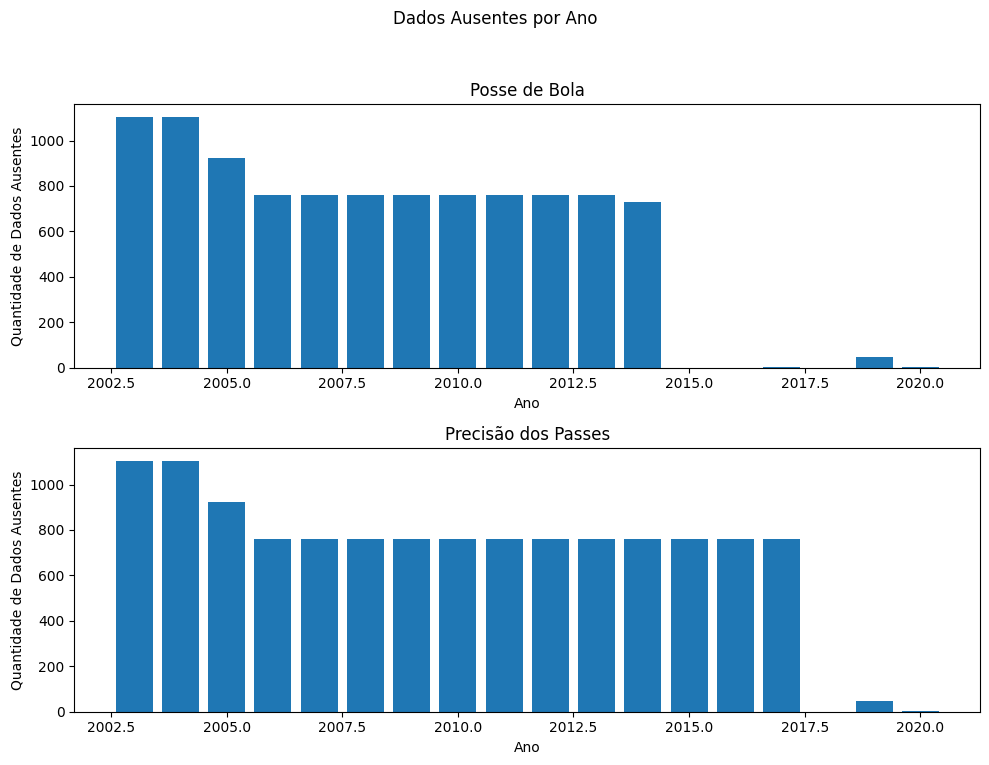

In [ ]:
# Função para contar dados ausentes por ano em uma coluna específica
def count_missing_by_year(df, column_name):
    return df[df[column_name].isnull()].groupby('ano').size()

# Contar dados ausentes por ano para as colunas 'posse_de_bola' e 'precisao_dos_passes'
missing_posse_de_bola = count_missing_by_year(df_estatisticas, 'posse_de_bola')
missing_precisao_dos_passes = count_missing_by_year(df_estatisticas, 'precisao_dos_passes')

# Configurar subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Dados Ausentes por Ano')

# Plotar histogramas
axs[0].bar(missing_posse_de_bola.index, missing_posse_de_bola.values)
axs[0].set_title('Posse de Bola')
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Quantidade de Dados Ausentes')

axs[1].bar(missing_precisao_dos_passes.index, missing_precisao_dos_passes.values)
axs[1].set_title('Precisão dos Passes')
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Quantidade de Dados Ausentes')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
df_estatisticas[df_estatisticas['ano'] > 2017].isnull().sum()

ID                      0
ano                     0
rodada                  0
clube                   0
vencedor                0
gols_marcados           0
gols_recebidos          0
chutes                  0
chutes_a_gol            0
posse_de_bola          48
passes                  0
precisao_dos_passes    48
faltas                  0
cartao_amarelo          0
cartao_vermelho         0
impedimentos            0
escanteios              0
mandante                0
dtype: int64

In [ ]:
df_estatisticas[df_estatisticas['ano'] > 2017]

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
12250,6126,2018,1,Cruzeiro,0,0,1,12,2,0.40,425,0.81,20,3,0,0,7,1
12251,6126,2018,1,Gremio,3,1,0,6,2,0.60,649,0.86,15,1,1,3,4,0
12252,6127,2018,1,Vitoria,1,2,2,21,6,0.66,545,0.88,24,3,0,2,4,1
12253,6127,2018,1,Flamengo,1,2,2,10,5,0.34,286,0.72,10,2,1,2,5,0
12254,6128,2018,1,Santos,3,2,0,22,3,0.54,532,0.90,7,0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,8403,2023,38,Santos,0,1,2,15,6,0.55,353,0.77,15,2,0,4,10,1
16806,8404,2023,38,Sao Paulo,3,1,0,9,3,0.42,406,0.84,13,0,0,2,4,1
16807,8404,2023,38,Flamengo,0,0,1,10,2,0.58,535,0.89,16,3,0,0,9,0
16808,8405,2023,38,Vasco,3,2,1,13,6,0.45,321,0.78,8,3,0,0,2,1


Decidimos focar na imputação dos dados ausentes nas colunas `posse_de_bola` e `precisao_dos_passes` a partir de 2018, pois os dados estavam completos a partir desse ano, com poucas exceções. Optamos por usar interpolação linear para preencher esses valores ausentes, devido à sua simplicidade e eficácia em lidar com dados temporais.

In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2017]['posse_de_bola'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2017]['posse_de_bola'].median())

0.5
0.5


In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2017]['precisao_dos_passes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2017]['precisao_dos_passes'].median())

0.8043373226950353
0.81


In [ ]:
# Filtrando os dados após 2018
df_pos_2018 = df_estatisticas[df_estatisticas['ano'] >= 2018]

# Imputação de valores ausentes para 'posse_de_bola' e 'precisao_dos_passes' usando interpolação com método 'spearman'
df_pos_2018['posse_de_bola'] = df_pos_2018['posse_de_bola'].interpolate(method='linear')
df_pos_2018['precisao_dos_passes'] = df_pos_2018['precisao_dos_passes'].interpolate(method='linear')

# Atualizando o dataframe original com os valores imputados
df_estatisticas.update(df_pos_2018)

<ipython-input-32-8d05867c49ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_2018['posse_de_bola'] = df_pos_2018['posse_de_bola'].interpolate(method='linear')
<ipython-input-32-8d05867c49ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_2018['precisao_dos_passes'] = df_pos_2018['precisao_dos_passes'].interpolate(method='linear')


In [ ]:
df_estatisticas[df_estatisticas['ano'] > 2017].isnull().sum()

ID                     0
ano                    0
rodada                 0
clube                  0
vencedor               0
gols_marcados          0
gols_recebidos         0
chutes                 0
chutes_a_gol           0
posse_de_bola          0
passes                 0
precisao_dos_passes    0
faltas                 0
cartao_amarelo         0
cartao_vermelho        0
impedimentos           0
escanteios             0
mandante               0
dtype: int64

In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2017]['posse_de_bola'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2017]['posse_de_bola'].median())

0.4998355263157895
0.5


In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2017]['precisao_dos_passes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2017]['precisao_dos_passes'].median())

0.804359649122807
0.81


Também, podemos pecerber que além dos valores ausentes temos alguns numeros estranhos como 0 chutes e 0 passes em uma partida. Então, vamos analisar também se esses dados começaram a ser computados depois de um determinado tempo.

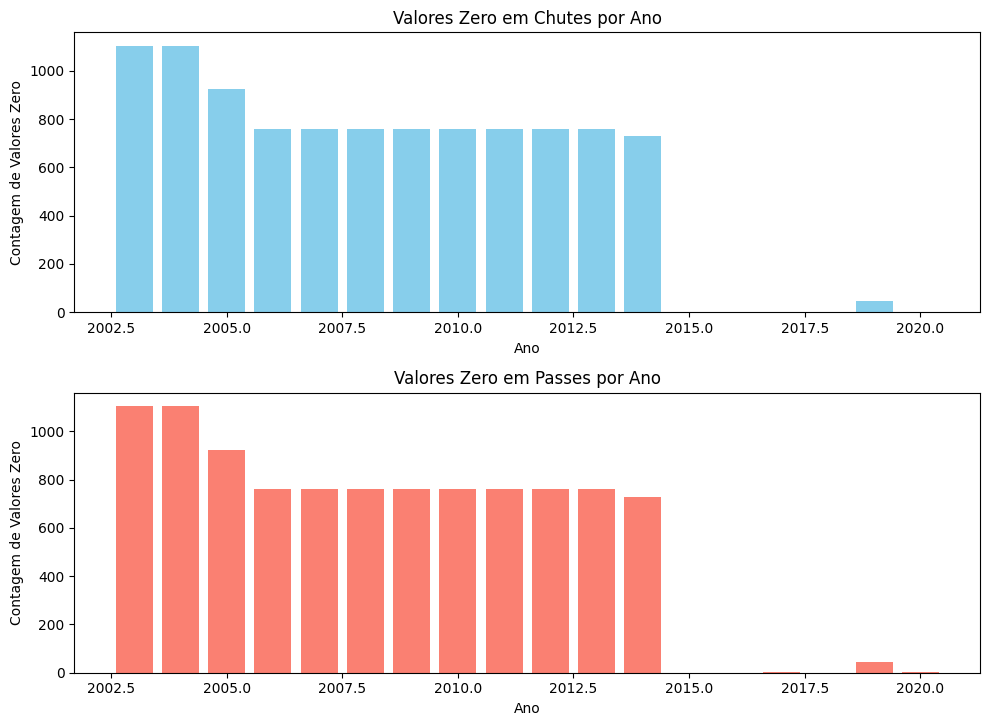

In [ ]:
#Contando valores zero por ano para as colunas especificadas
zeros_chutes = df_estatisticas[df_estatisticas['chutes'] == 0].groupby('ano').size()
zeros_passes = df_estatisticas[df_estatisticas['passes'] == 0].groupby('ano').size()

# Plotando histogramas
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].bar(zeros_chutes.index, zeros_chutes.values, color='skyblue')
axs[0].set_title('Valores Zero em Chutes por Ano')
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Contagem de Valores Zero')

axs[1].bar(zeros_passes.index, zeros_passes.values, color='salmon')
axs[1].set_title('Valores Zero em Passes por Ano')
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Contagem de Valores Zero')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def contar_valores_zero(df, colunas, ano_inicio):
    df_intervalo = df[df['ano'] >= ano_inicio]
    contagens = {coluna: (df_intervalo[coluna] == 0).sum() for coluna in colunas}
    return contagens

# Definindo o intervalo de tempo e as colunas a serem analisadas
ano_inicio = 2015
colunas_analisadas = ['chutes', 'passes']

# Contando os valores zero no intervalo especificado
contagens_zero = contar_valores_zero(df_estatisticas, colunas_analisadas, ano_inicio)

# Exibindo os resultados
for coluna, contagem in contagens_zero.items():
    print(f"Valores zero na coluna '{coluna}' entre {ano_inicio}: {contagem}")

Valores zero na coluna 'chutes' entre 2015: 50
Valores zero na coluna 'passes' entre 2015: 50


In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2014]['chutes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2014]['chutes'].median())

12.808277274056742
12.0


In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2014]['passes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2014]['passes'].median())

419.0668324071366
416.0


Decidimos, de forma análoga aos dados ausentes nas colunas `posse_de_bola` e `precisao_dos_passes`, focar na imputação dos a partir de 2015 dos dados de `chutes` e `passes`, pois os dados estavam completos a partir desse ano, com poucas exceções.

In [ ]:
# Filtrando os dados a partir de 2015
df_pos_2015 = df_estatisticas[df_estatisticas['ano'] >= 2015]

# Imputação de valores zero para 'chutes' e 'passes' usando interpolação com método 'linear'
df_pos_2015['chutes'] = df_pos_2015['chutes'].replace(0, np.nan)
df_pos_2015['passes'] = df_pos_2015['passes'].replace(0, np.nan)

df_pos_2015['chutes'] = df_pos_2015['chutes'].interpolate(method='linear')
df_pos_2015['passes'] = df_pos_2015['passes'].interpolate(method='linear')

# Atualizando o dataframe original com os valores imputados
df_estatisticas.update(df_pos_2015)

<ipython-input-40-9967db33ec91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_2015['chutes'] = df_pos_2015['chutes'].replace(0, np.nan)
<ipython-input-40-9967db33ec91>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_2015['passes'] = df_pos_2015['passes'].replace(0, np.nan)
<ipython-input-40-9967db33ec91>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2014]['chutes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2014]['chutes'].median())

12.906844106463879
12.0


In [ ]:
print(df_estatisticas[df_estatisticas['ano'] > 2014]['passes'].mean())
print(df_estatisticas[df_estatisticas['ano'] > 2014]['passes'].median())

422.1243053524422
417.0


Por último, para analisar a incidência de valores zero nas colunas `chutes_a_gol`, `faltas`, `cartao_amarelo`, `cartao_vermelho`, `impedimentos` e `escanteios`, vamos verificar se houve algum ano em que essas estatísticas começaram a ser computadas.

Primeiro ano de registro de cada estatística:
chutes_a_gol: 2015
faltas: 2014
cartao_amarelo: 2014
cartao_vermelho: 2015
impedimentos: 2014
escanteios: 2014


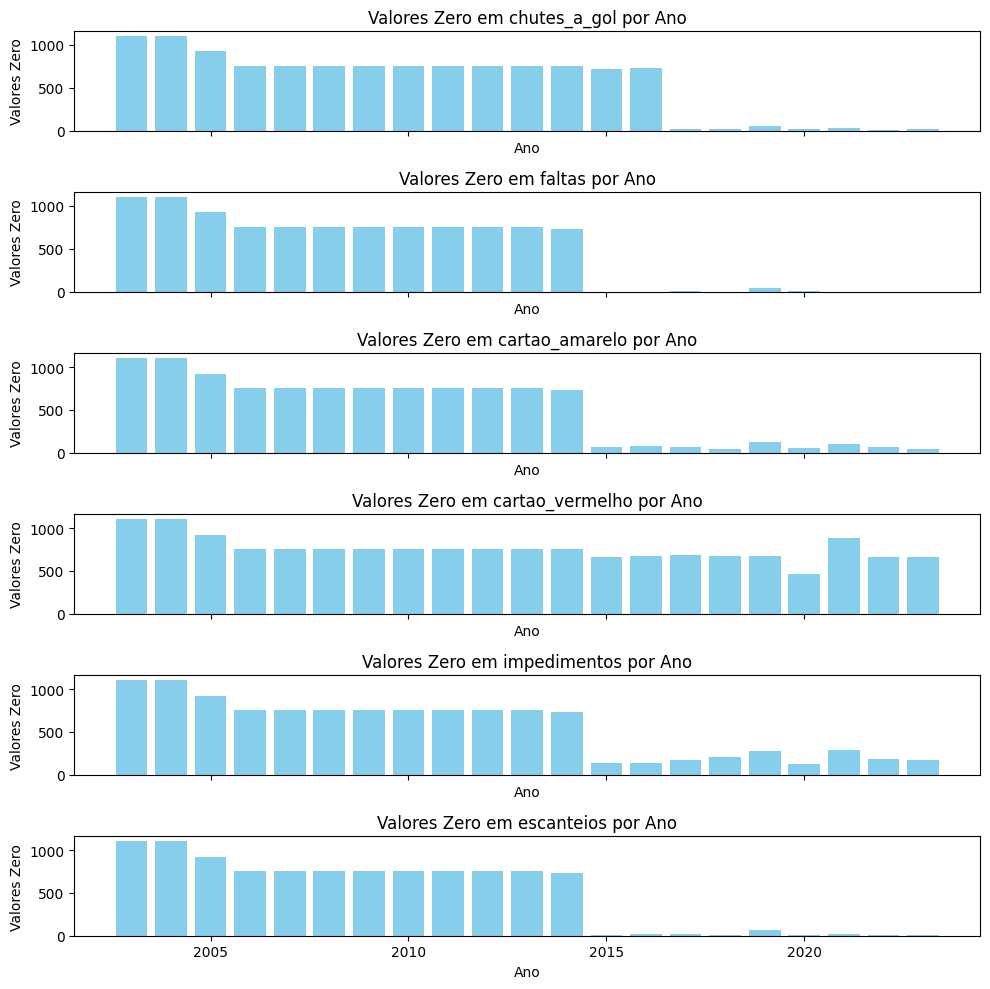

In [ ]:
# Lista das colunas que queremos analisar
colunas_analisadas = ['chutes_a_gol', 'faltas', 'cartao_amarelo', 'cartao_vermelho', 'impedimentos', 'escanteios']

# Dicionário para armazenar o primeiro ano de registro de cada estatística
primeiro_ano = {}

# Identificando o primeiro ano de registro de cada estatística
for coluna in colunas_analisadas:
    primeiro_ano[coluna] = df_estatisticas[df_estatisticas[coluna] > 0]['ano'].min()

# Imprimindo o primeiro ano de registro de cada estatística
print("Primeiro ano de registro de cada estatística:")
for coluna, ano in primeiro_ano.items():
    print(f"{coluna}: {ano}")

# Contando o número de valores zero em cada coluna para cada ano
valores_zero_por_ano = {}
for coluna in colunas_analisadas:
    valores_zero_por_ano[coluna] = df_estatisticas[df_estatisticas[coluna] == 0].groupby('ano').size()

# Plotando os resultados em um gráfico
fig, axs = plt.subplots(len(colunas_analisadas), 1, figsize=(10, 10), sharex=True)

for i, coluna in enumerate(colunas_analisadas):
    axs[i].bar(valores_zero_por_ano[coluna].index, valores_zero_por_ano[coluna].values, color='skyblue')
    axs[i].set_title(f'Valores Zero em {coluna} por Ano')
    axs[i].set_xlabel('Ano')
    axs[i].set_ylabel('Valores Zero')

plt.tight_layout()
plt.show()

Podemos analisar por esses graficos que as colunas `chutes_a_gol`, `faltas`, `cartao_amarelo`, `cartao_vermelho`, `impedimentos` e `escanteios` começaram a ser computados por volta de 2015. Apesar de existirem valores zeros nos posteriotres não é interessante fazemos uma imputação de dados como as outras colunas já que esses dados podem ter valores zeros no contexto das partidas.

Com base em nossa análise, concluímos que

*   Para as colunas `posse_de_bola` e `precisao_dos_passes`, a partir de 2018 é a melhor faixa de tempo para análise, pois é quando essas estatísticas começaram a ser consistentemente registradas.

*   Para as colunas `chutes`, `passes`, `chutes_a_gol`, `faltas`, `cartao_amarelo`, `cartao_vermelho`, `impedimentos` e `escanteios`, a partir de 2015 é a melhor faixa de tempo para análise, pois é quando essas estatísticas começaram a ser consistentemente registradas.



In [ ]:
# Filtrar o DataFrame para incluir apenas os dados a partir de 2018
df_filtrado_2018 = df_estatisticas[df_estatisticas['ano'] >= 2018]

# Selecionar apenas as colunas 'posse_de_bola' e 'precisao_dos_passes'
colunas_selecionadas = ['posse_de_bola', 'precisao_dos_passes']

# Fazer o describe para as colunas selecionadas
df_filtrado_2018[colunas_selecionadas].describe()

,posse_de_bola,precisao_dos_passes
count,4560.000000,4560.000000
mean,0.499836,0.804360
std,0.109878,0.059757
min,0.200000,0.390000
25%,0.420000,0.770000
50%,0.500000,0.810000
75%,0.580000,0.850000
max,0.800000,0.930000


In [ ]:
# Filtrar o DataFrame para incluir apenas os dados a partir de 2018
df_filtrado_2018 = df_estatisticas[df_estatisticas['ano'] >= 2015]

# Selecionar apenas as colunas 'posse_de_bola' e 'precisao_dos_passes'
colunas_selecionadas = ['chutes', 'passes', 'chutes_a_gol', 'faltas',
                     'cartao_amarelo', 'cartao_vermelho', 'impedimentos',
                     'escanteios']

# Fazer o describe para as colunas selecionadas
df_filtrado_2018[colunas_selecionadas].describe()

,chutes,passes,chutes_a_gol,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
count,6838.000000,6838.000000,6838.000000,6838.000000,6838.000000,6838.000000,6838.000000,6838.000000
mean,12.906844,422.124305,3.341620,14.844838,2.301843,0.127669,1.624305,5.200936
std,5.011635,99.833708,2.718416,4.632215,1.451623,0.367533,1.501004,3.006597
min,1.000000,169.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,350.000000,1.000000,12.000000,1.000000,0.000000,1.000000,3.000000
50%,12.000000,417.000000,3.000000,15.000000,2.000000,0.000000,1.000000,5.000000
75%,16.000000,488.000000,5.000000,18.000000,3.000000,0.000000,2.000000,7.000000
max,37.000000,848.000000,18.000000,34.000000,10.000000,3.000000,10.000000,23.000000


### **Detecção de outliers:**

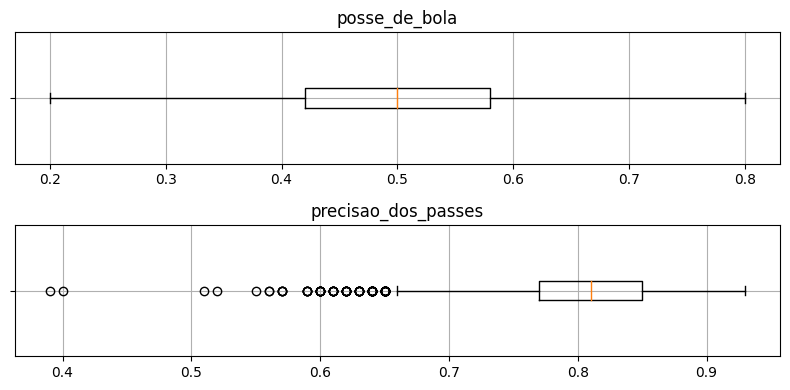

In [ ]:
colunas_numericas = ['posse_de_bola', 'precisao_dos_passes']

# Filtrar os dados para os períodos especificados
df_filtrado = df_estatisticas[df_estatisticas['ano'] >= 2018]

fig, axs = plt.subplots(nrows=len(colunas_numericas), figsize=(8, 2 * len(colunas_numericas)))

# Loop sobre as colunas numéricas
for i, coluna in enumerate(colunas_numericas):
    axs[i].boxplot(df_filtrado[coluna].dropna(), vert=False)
    axs[i].set_title(coluna)
    axs[i].set_yticklabels([])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

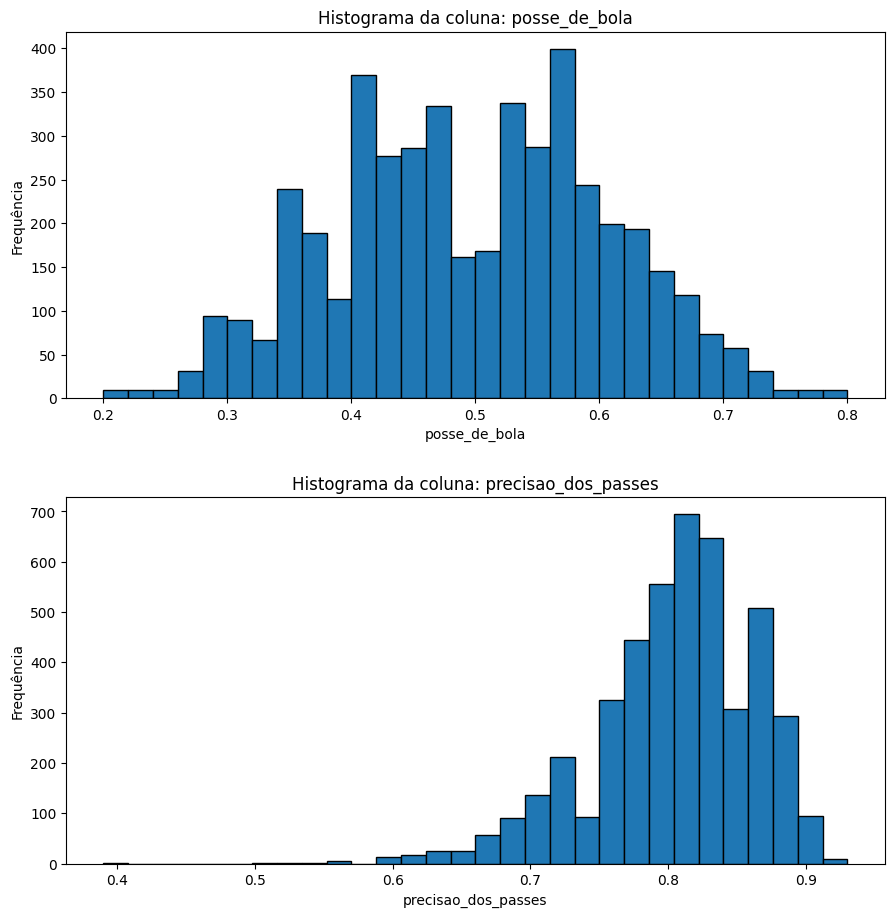

In [ ]:
colunas_numericas = ['posse_de_bola', 'precisao_dos_passes']

# Filtrar os dados para os períodos especificados
df_filtrado = df_estatisticas[df_estatisticas['ano'] >= 2018]

# Cria um histograma para cada coluna numérica
fig, axes = plt.subplots(len(colunas_numericas), 1, figsize=(10, 5 * len(colunas_numericas)))
fig.tight_layout(pad=5.0)

for i, column in enumerate(colunas_numericas):
    axes[i].hist(df_filtrado[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f'Histograma da coluna: {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequência')

plt.show()

Olhando esses gráficos, podemos perceber alguns dados de precisão de passes que estão muito distantes. Vamos investigar esses dados para descobrir se podem ser erros no registro de dados:

In [ ]:
df_estatisticas[df_estatisticas['precisao_dos_passes'] < 0.5]

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
15460,7731,2022,9,Juventude,3,1,0,11.0,3,0.48,251.0,0.40,21,3,0,5,5,1
15461,7731,2022,9,Fluminense,0,0,1,6.0,2,0.52,259.0,0.39,10,4,1,1,7,0


Interessante! Pela tabela acima percebemos que os maiores outliers da precisão de passes aconteceu na mesma partida. <br>
Pesquisando na internet por essa partida entre Juventude x Fluminense, encontrei o seguinte:

> "Com muita chuva e gramado pesado, cheio de poças, o que menos aconteceu em Caxias do Sul neste domingo de manhã foi uma partida de futebol com alguma qualidade. Poucas trocas de passes, muitos erros e chutes para o ataque em busca de ligação direta. Porque também era a única possibilidade nas condições que o campo apresentava." - Globo Esporte

Logo, percebe-se que a baixa precisão dos passes da partida aconteceram devido as péssimas condições do gramado devido a chuva, e assim as poças de água no campo impediam que os passes fossem realizados com sucesso. <br>

Assim, percebemos que os dados apresentados nas colunas de posse de bola e precisão dos passes possuem outliers, mas que são dados reais, logo foi decidido mantes esses dados do dataset.

Seguindo a análise de outliers para as outras variáveis numéricas:

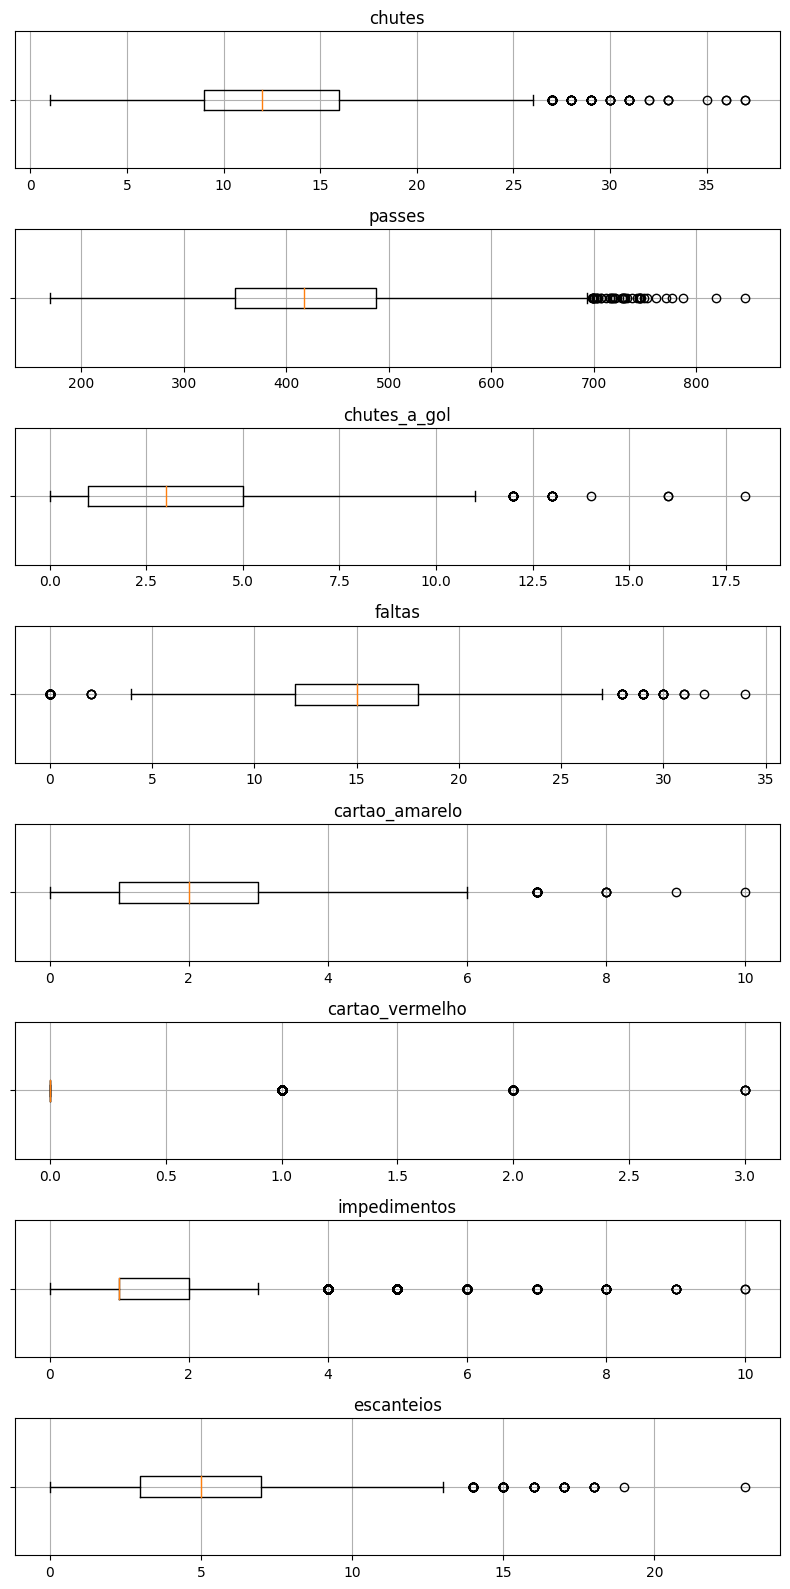

In [ ]:
colunas_numericas = ['chutes', 'passes', 'chutes_a_gol', 'faltas',
                     'cartao_amarelo', 'cartao_vermelho', 'impedimentos',
                     'escanteios']

# Filtrar os dados para os períodos especificados
df_filtrado = df_estatisticas[df_estatisticas['ano'] >= 2015]

# Configurar a figura e os eixos
fig, axs = plt.subplots(nrows=len(colunas_numericas), figsize=(8, 2 * len(colunas_numericas)))

# Loop sobre as colunas numéricas
for i, coluna in enumerate(colunas_numericas):
    # Criar um boxplot para a coluna atual
    axs[i].boxplot(df_filtrado[coluna].dropna(), vert=False)
    axs[i].set_title(coluna)
    axs[i].set_yticklabels([])
    axs[i].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

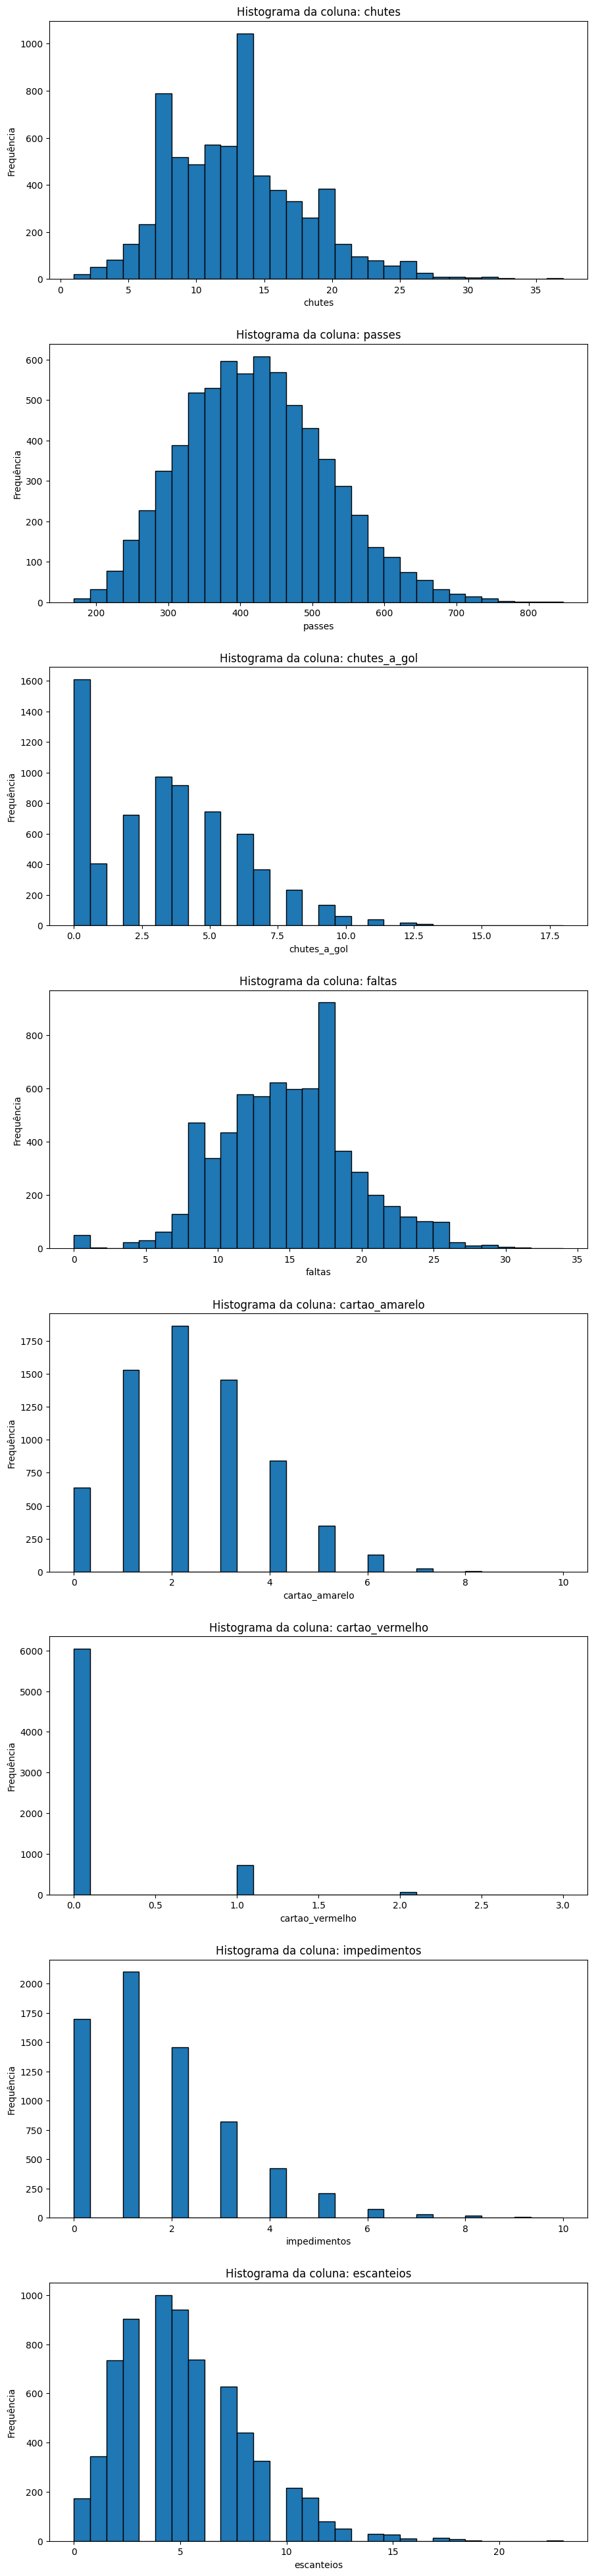

In [ ]:
colunas_numericas = ['chutes', 'passes', 'chutes_a_gol', 'faltas',
                     'cartao_amarelo', 'cartao_vermelho', 'impedimentos',
                     'escanteios']

# Filtrar os dados para os períodos especificados
df_filtrado = df_estatisticas[df_estatisticas['ano'] >= 2015]

# Cria um histograma para cada coluna numérica
fig, axes = plt.subplots(len(colunas_numericas), 1, figsize=(10, 5 * len(colunas_numericas)))
fig.tight_layout(pad=5.0)

for i, column in enumerate(colunas_numericas):
    axes[i].hist(df_filtrado[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f'Histograma da coluna: {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequência')

plt.show()

Analisando esses gráficos, podemos afirmar que os dados parecem ser reais, pois não apresentam valores absurdos fora da realidade das partidas de futebol. No entanto, alguns outliers, especialmente nas colunas de cartões amarelos e escanteios, chamam a atenção e merecem ser melhor analisados:

In [ ]:
df_estatisticas[df_estatisticas['escanteios'] >= 20]

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
15077,7545,2021,28,Palmeiras,3,2,1,37.0,16,0.65,472.0,0.84,10,1,0,1,23,1


In [ ]:
df_estatisticas[df_estatisticas['ID'] == 7545]

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
15076,7545,2021,28,Sport,0,1,2,6.0,1,0.35,284.0,0.70,20,3,0,0,0,0
15077,7545,2021,28,Palmeiras,3,2,1,37.0,16,0.65,472.0,0.84,10,1,0,1,23,1


Essa partida foi marcada pelo domínio do Palmeiras que brigava na ponta de cima da tabela em relação ao Sport que brigava pra fugir do rebaixamento.
Essa superioridade do Palmeiras foi refletida na quantidade de escanteios e, pasmem, os dois gols do Palmeiras nesse jogo foram feitos em 2 desses 23 escanteios a favor!

Analisando agora os outliers de cartões amarelos pela tabela abaixo, podemos perceber que as partidas que hoveram muitos cartões, foram também as partidas que apresentaram bastante faltas.

Em particular, o caso do Botafogo chamou atenção, pois recebeu 10 cartões com apenas 13 faltas cometidas. Ao analisar o que aconteceu nesse jogo, percebemos que foi um jogo polêmico em relação à arbitragem, e 4 desses cartões recebidos foram pelo Botafogo foram por reclamação a arbitragem. <br>

No caso do Ceará algo parecido aconteceu. 3 cartões foram por conta de confusão e 1 por conta da famosa "cera".

In [ ]:
df_estatisticas[df_estatisticas['cartao_amarelo'] >= 8]

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
11744,5873,2017,13,Chapecoense,0,0,3,11.0,1,0.47,346.0,NaN,26,8,0,1,8,0
11782,5892,2017,15,Palmeiras,1,2,2,7.0,5,0.38,286.0,NaN,23,9,0,0,2,0
12477,6240,2018,12,Parana,1,1,1,7.0,1,0.43,365.0,0.80,23,8,0,1,3,1
13110,6556,2019,6,Botafogo-RJ,0,0,1,8.0,2,0.63,444.0,0.84,13,10,0,0,0,1
15294,7648,2022,1,Ceara,3,3,2,19.0,9,0.44,309.0,0.69,14,8,1,0,8,0
16309,8155,2023,13,Coritiba,3,2,1,13.0,8,0.35,276.0,0.68,24,8,0,1,2,0


#### Conclusão análise de outliers

Os gráficos dos dados numéricos apresentaram alguns outliers, mas nenhum foi absurdamente diferente. Alguns dados se destacaram por destoarem um pouco mais, mas ainda representam eventos reais que ocorreram nas partidas de futebol. <br>

Portanto, considerando que a análise de outliers confirmou a representação real das possíveis variações nas partidas, foi decidido manter todos esses dados.

### **Normalização dos dados:**

Neste projeto de análise do Campeonato Brasileiro de Futebol, optamos pela normalização Min-Max pelos seguintes motivos:

* Mantém a relação entre os valores: Dimensiona os dados para um intervalo específico (geralmente entre 0 e 1), preservando a relação relativa entre os valores originais.

* Facilita a comparação: Torna mais fácil comparar diferentes estatísticas entre si, identificando padrões e tendências ao longo do tempo ou entre diferentes times.

* Reduz a sensibilidade a outliers: Menos sensível a valores atípicos em comparação com outras técnicas de normalização, o que é importante para dados de futebol que podem conter eventos raros durante as partidas.

* Simplicidade e interpretabilidade: Fácil de entender e implementar, mantendo a interpretabilidade dos dados para comunicação eficaz dos resultados.

In [ ]:
# Selecionar as colunas que serão normalizadas
colunas_normalizacao = ['posse_de_bola', 'chutes', 'passes', 'chutes_a_gol',
                        'faltas', 'cartao_amarelo', 'cartao_vermelho',
                        'impedimentos', 'escanteios', 'precisao_dos_passes']

# Criar um MinMaxScaler e um StandardScaler
scaler_minmax = MinMaxScaler()

# Normalização Min-Max
df_estatisticas_minmax = df_estatisticas.copy()
df_estatisticas_minmax[colunas_normalizacao] = scaler_minmax.fit_transform(df_estatisticas_minmax[colunas_normalizacao])

In [ ]:
print("DataFrame após Normalização Min-Max:")
df_estatisticas_minmax.tail()

DataFrame após Normalização Min-Max:


,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
16805,8403,2023,38,Santos,0,1,2,0.405405,0.333333,0.583333,0.416274,0.703704,0.441176,0.2,0.000000,0.4,0.434783,1
16806,8404,2023,38,Sao Paulo,3,1,0,0.243243,0.166667,0.366667,0.478774,0.833333,0.382353,0.0,0.000000,0.2,0.173913,1
16807,8404,2023,38,Flamengo,0,0,1,0.270270,0.111111,0.633333,0.630896,0.925926,0.470588,0.3,0.000000,0.0,0.391304,0
16808,8405,2023,38,Vasco,3,2,1,0.351351,0.333333,0.416667,0.378538,0.722222,0.235294,0.3,0.000000,0.0,0.086957,1
16809,8405,2023,38,Bragantino,0,1,2,0.243243,0.111111,0.583333,0.469340,0.759259,0.411765,0.1,0.333333,0.1,0.130435,0


## **4. Análise Descritiva e Visualização:**

### **Quantidade de jogos por temporada:**

In [ ]:
jogos_por_ano = df_estatisticas.groupby('ano')['ID'].nunique()

print(jogos_por_ano)

ano
2003    552
2004    552
2005    462
2006    380
2007    380
2008    380
2009    380
2010    380
2011    380
2012    380
2013    380
2014    380
2015    380
2016    379
2017    380
2018    380
2019    380
2020    268
2021    492
2022    380
2023    380
Name: ID, dtype: int64


Vamos analisar cada ano com base no histórico do campeonato:

* 2003-2004: Em 2003 e 2004, o Campeonato Brasileiro adotou o formato de pontos corridos com 24 equipes, totalizando 552 jogos por temporada (cada time jogando 23 jogos em casa e 23 fora).

* 2005: A partir de 2005, o número de equipes foi reduzido para 22, resultando em 462 jogos na temporada.

* 2006 em diante: Em 2006, o formato mudou para 20 equipes, o que permanece até hoje. Cada time joga 38 jogos por temporada (19 em casa e 19 fora), resultando em 380 jogos por temporada.

* 2016: A inconsistência em 2016, com 379 jogos, foi devido ao jogo que foi cancelado na última rodada entre a Chapecoense e o Atlético Mineiro. Devido tragédia que ocorreu em 28 de novembro de 2016, quando o avião que transportava a equipe da Chapecoense caiu. A última rodada do Campeonato Brasileiro de 2016 foi cancelada, com a Chapecoense sendo declarada campeã da Copa Sul-Americana em homenagem às vítimas

* 2020: A temporada de 2020 foi atípica devido à pandemia de COVID-19, que resultou em uma série de adiamentos e ajustes no calendário. A quantidade de jogos reduzida (268) pode refletir esses ajustes e possíveis cancelamentos.

* 2021: A temporada de 2021 mostra um aumento para 492 jogos. Isso pode indicar a inclusão de competições adicionais ou uma incorporação de jogos adiados de 2020 devido à pandemia.

* 2022-2023: O campeonato voltou ao formato normal com 380 jogos por temporada, o que indica uma normalização após os ajustes causados pela pandemia.

### **Frequencia dos Times no Campeonato:**

A variável clube é a única variável categórica e com ela podemos ver a frequência dos clubes no Campeonato Brasileiro de Futebol entre 2003 e 2023

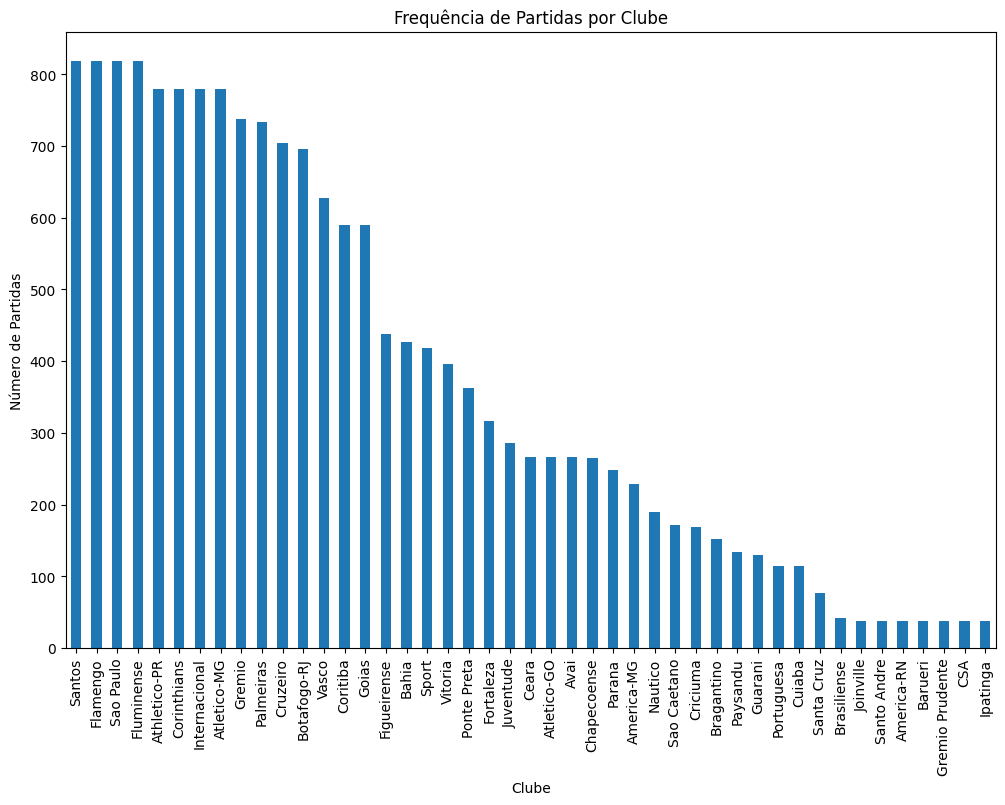

In [ ]:
# Frequência de cada clube
clube_freq = df_estatisticas['clube'].value_counts()
# print(clube_freq)

# Visualização da frequência de cada clube
plt.figure(figsize=(12, 8))
clube_freq.plot(kind='bar')
plt.title('Frequência de Partidas por Clube')
plt.xlabel('Clube')
plt.ylabel('Número de Partidas')
plt.xticks(rotation=90)
plt.show()

A análise da frequência dos clubes no Campeonato Brasileiro de Futebol entre 2003 e 2023 destaca a dominância de certos clubes com presença constante, como Santos, Flamengo, São Paulo e Fluminense. Além disso, clubes como Grêmio, Palmeiras e Cruzeiro também mostraram uma participação significativa. Por outro lado, clubes com menor frequência, como CSA e Ipatinga, tiveram participações mais esporádicas. Esta distribuição reflete a competitividade e a dinâmica do futebol brasileiro, onde alguns clubes mantêm uma presença constante, enquanto outros têm participações mais variáveis.

### **Análise dos Resultados das Partidas**

#### **Distribuição de Resultados (vencedor):**

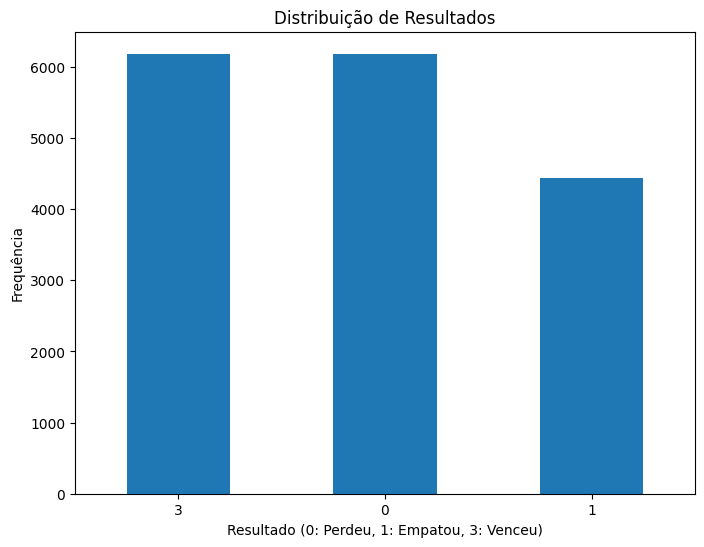

In [ ]:
# Distribuição de resultados
vencedor_freq = df_estatisticas['vencedor'].value_counts()

# Visualização da distribuição de resultados
plt.figure(figsize=(8, 6))
vencedor_freq.plot(kind='bar')
plt.title('Distribuição de Resultados')
plt.xlabel('Resultado (0: Perdeu, 1: Empatou, 3: Venceu)')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()

A partir da analise desse grafico podemos afirmar que a consistencia dele parece está certa ja que existe uma igualdade no número de derrotas e vitorias como deveria ser.

#### **Distribuição de gols:**

Vamos analisar a distribuição de gols marcados por mandantes e visitantes.

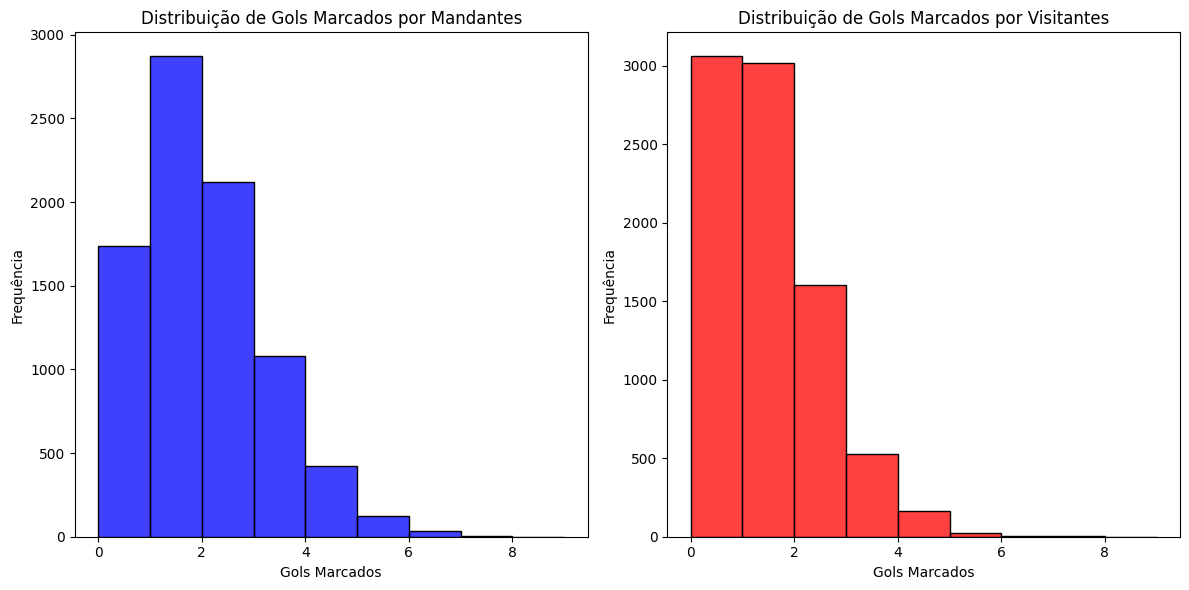

In [ ]:
# Gols marcados por mandantes
gols_mandantes = df_estatisticas[df_estatisticas['mandante'] == 1]['gols_marcados']

# Gols marcados por visitantes
gols_visitantes = df_estatisticas[df_estatisticas['mandante'] == 0]['gols_marcados']

# Plotar a distribuição de gols marcados por mandantes e visitantes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(gols_mandantes, bins=range(0, 10), kde=False, color='blue')
plt.title('Distribuição de Gols Marcados por Mandantes')
plt.xlabel('Gols Marcados')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(gols_visitantes, bins=range(0, 10), kde=False, color='red')
plt.title('Distribuição de Gols Marcados por Visitantes')
plt.xlabel('Gols Marcados')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


#### **Resultados por clube:**

Vamos analisar a performance de cada clube em termos de vitórias, empates e derrotas.

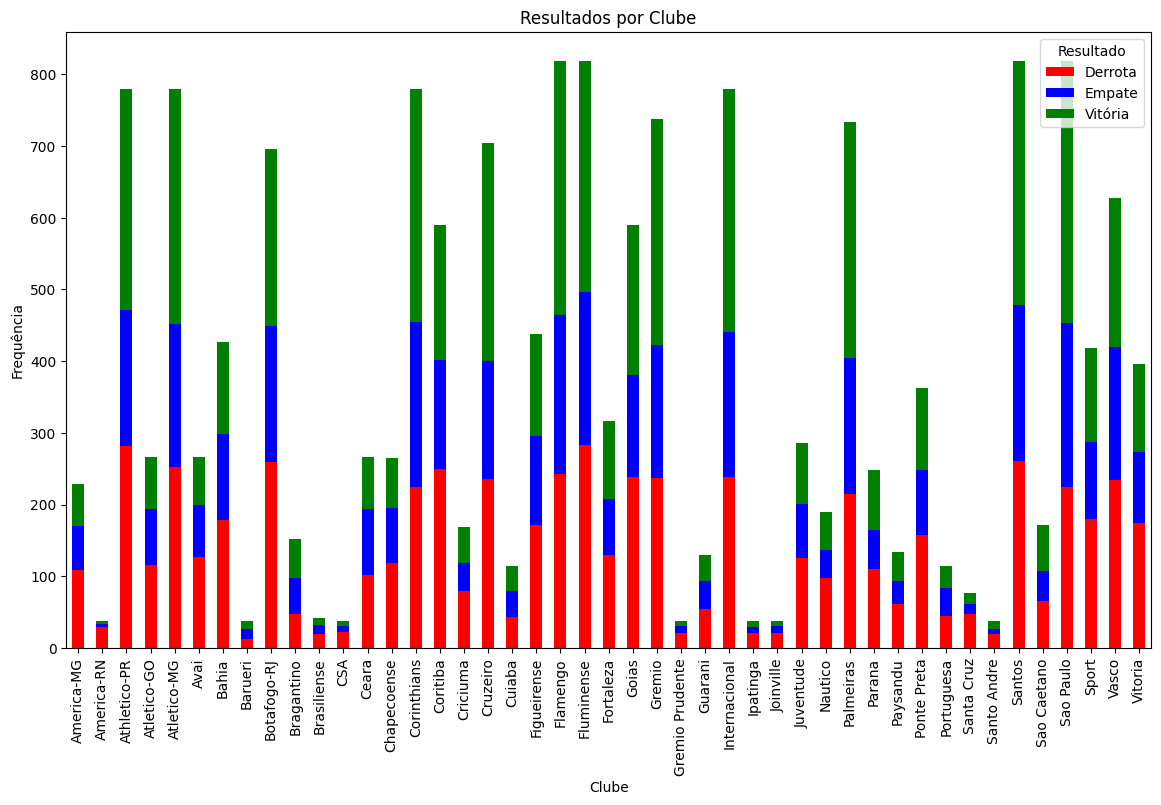

In [ ]:
# Contar vitórias, empates e derrotas por clube
clubes_resultados = df_estatisticas.groupby('clube')['vencedor'].value_counts().unstack().fillna(0)

# Renomear as colunas para melhor legibilidade
clubes_resultados.columns = ['Derrota', 'Empate', 'Vitória']

# Plotar os resultados por clube
clubes_resultados.plot(kind='bar', stacked=True, figsize=(14, 8), color=['red', 'blue', 'green'])
plt.title('Resultados por Clube')
plt.xlabel('Clube')
plt.ylabel('Frequência')
plt.legend(title='Resultado')
plt.show()

* Vantagem dos Clubes Tradicionais: Clubes com uma longa história no campeonato tendem a ter uma performance mais consistente, com um equilíbrio entre vitórias, empates e derrotas.
* Desempenho Variável: Clubes com menos jogos geralmente têm uma performance mais variada e menos previsível, com uma quantidade menor de vitórias e mais empates e derrotas.

#### **Top 15 Times com mais vitorias de todo campeonato:**

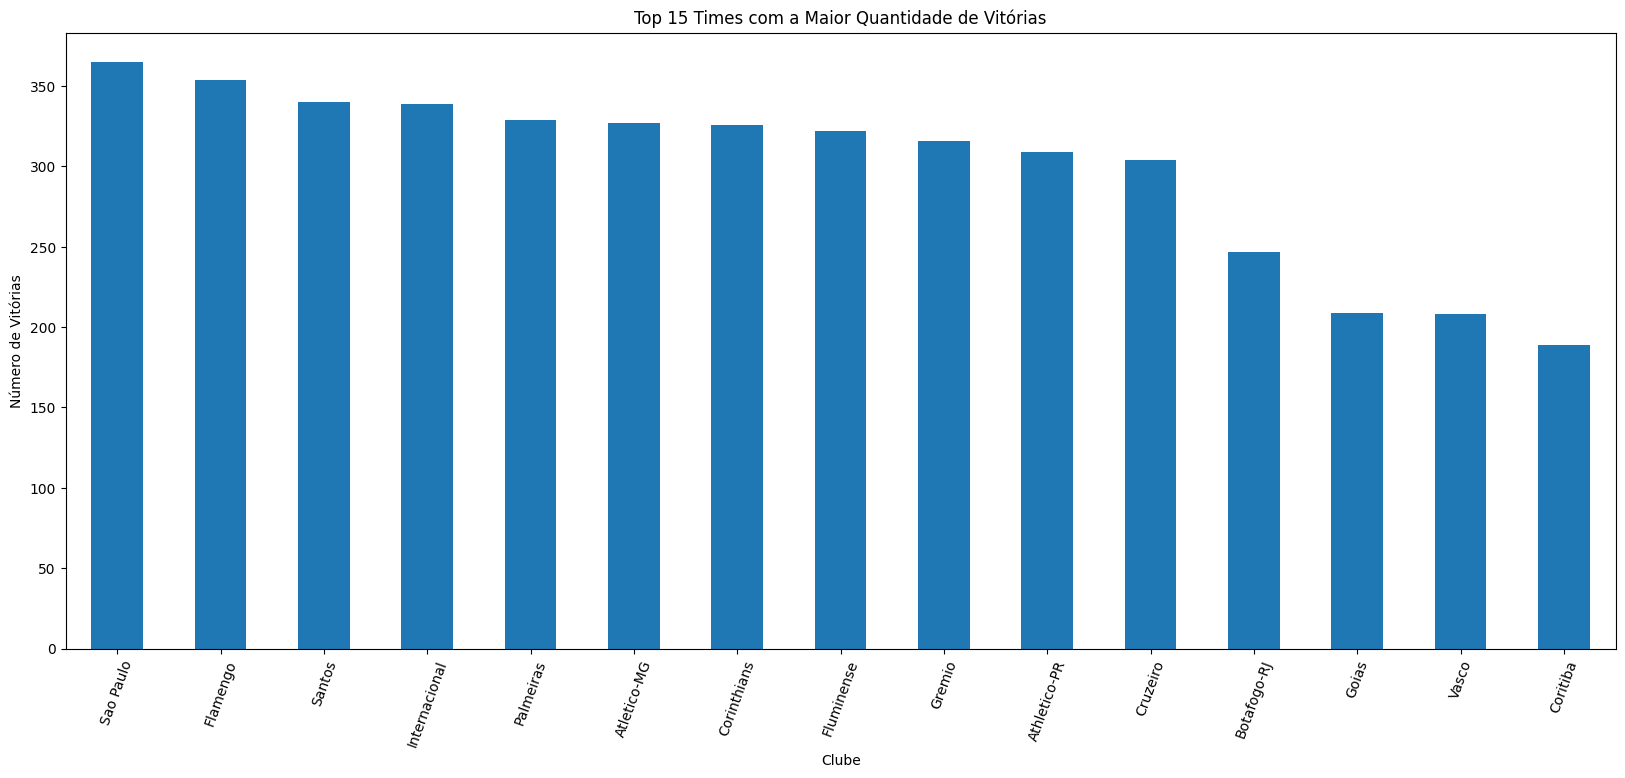

In [ ]:
vitorias_por_clube = df_estatisticas[df_estatisticas['vencedor'] == 3]['clube'].value_counts()

# Visualizar os times com a maior quantidade de vitórias
plt.figure(figsize=(20, 8))
vitorias_por_clube.head(15).plot(kind='bar')
plt.title('Top 15 Times com a Maior Quantidade de Vitórias')
plt.xlabel('Clube')
plt.ylabel('Número de Vitórias')
plt.xticks(rotation=70)
plt.show()

### **Análise de Desempenho dos Clubes**

#### **Posse de Bola: Comparar a posse de bola média entre clubes (após 2015)**

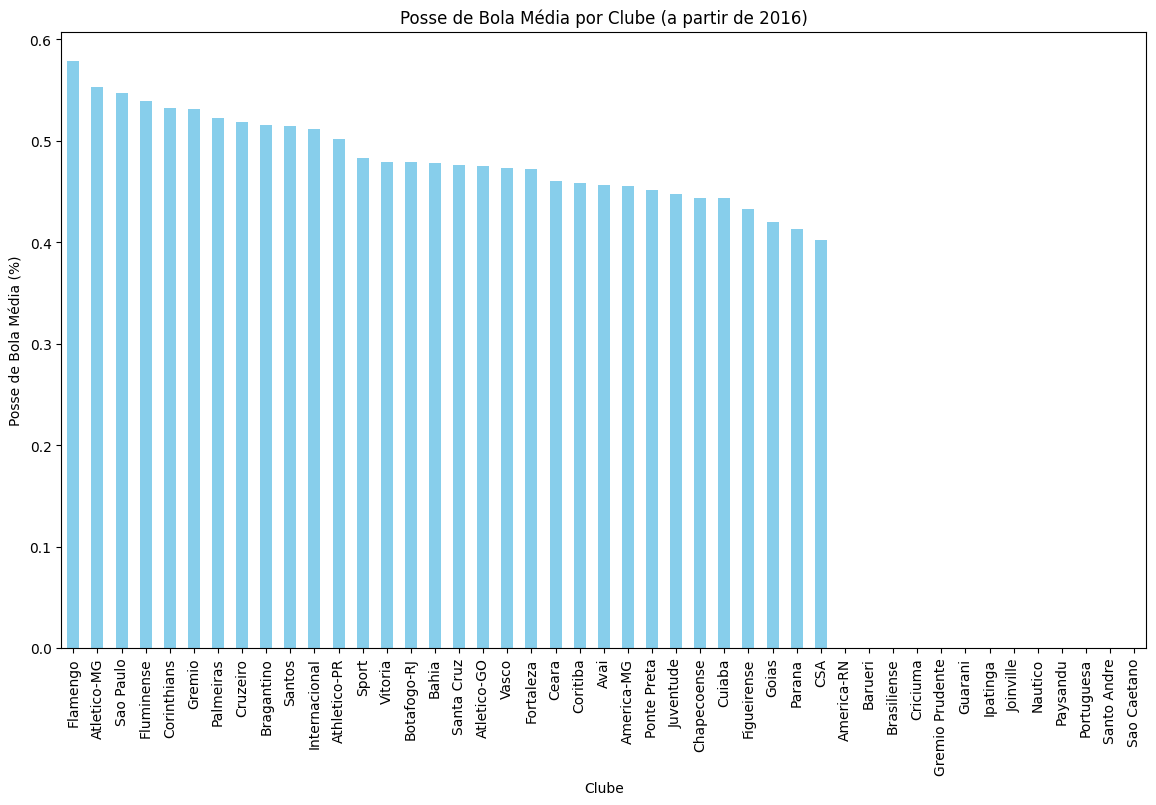

In [ ]:
# Filtrar dados a partir de 2016 para posse de bola
df_posse = df_estatisticas[df_estatisticas['ano'] > 2015]

# Calcular a posse de bola média por clube
posse_media_clube = df_posse.groupby('clube')['posse_de_bola'].mean().sort_values(ascending=False)

# Plotar a posse de bola média por clube
plt.figure(figsize=(14, 8))
posse_media_clube.plot(kind='bar', color='skyblue')
plt.title('Posse de Bola Média por Clube (a partir de 2016)')
plt.xlabel('Clube')
plt.ylabel('Posse de Bola Média (%)')
plt.show()

Os clubes de maior sucesso e mais tradicionais, como Flamengo, Atlético-MG, São Paulo, e Corinthians, tendem a manter uma maior posse de bola, o que pode refletir um estilo de jogo mais ofensivo e controlador. Clubes com menor posse de bola podem adotar estilos mais defensivos ou de contra-ataque.

America-RN, Barueri, Brasiliense, Criciúma, Gremio Prudente, Guarani, Ipatinga, Joinville, Náutico, Paysandu, Portuguesa, Santo André, São Caetano: Não têm dados suficientes para uma análise da posse de bola média.

#### **Precisão de Passes: Comparar a precisão de passes média entre clubes (após 2017)**

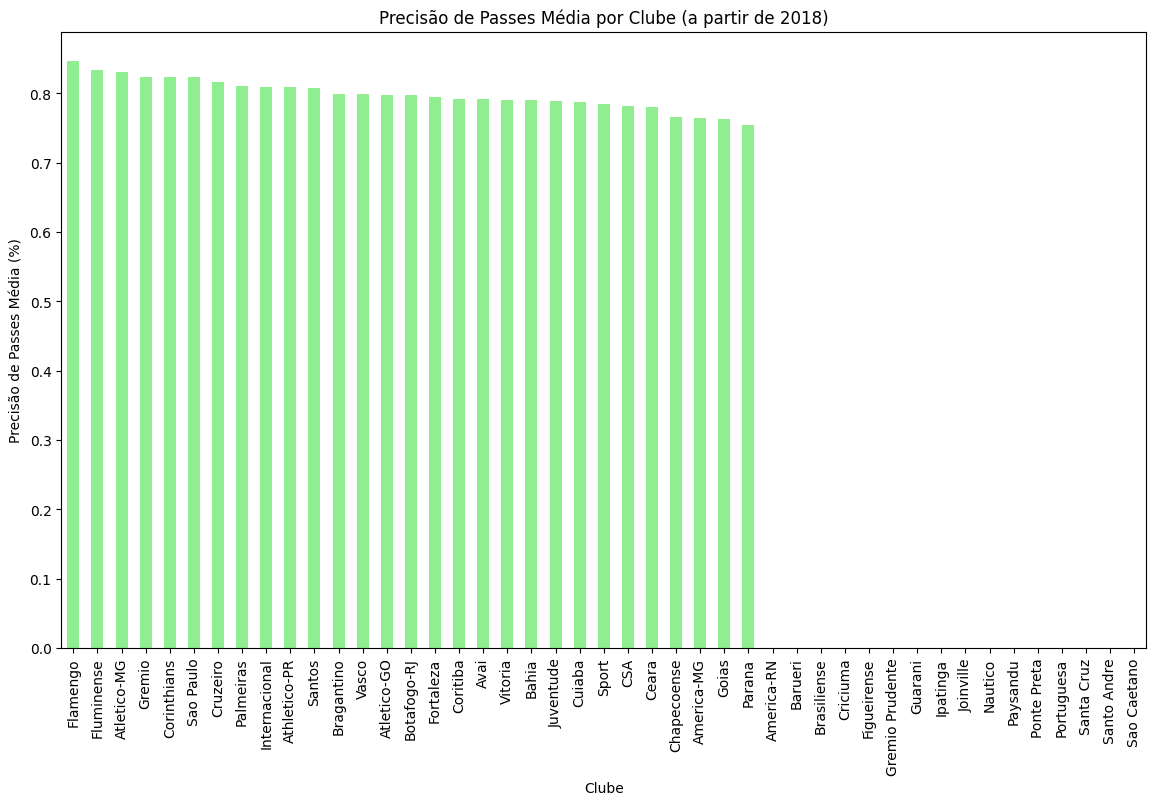

In [ ]:
# Filtrar dados a partir de 2018 para precisão de passes
df_precisao = df_estatisticas[df_estatisticas['ano'] > 2017]

# Calcular a precisão de passes média por clube
precisao_media_clube = df_precisao.groupby('clube')['precisao_dos_passes'].mean().sort_values(ascending=False)

# Plotar a precisão de passes média por clube
plt.figure(figsize=(14, 8))
precisao_media_clube.plot(kind='bar', color='lightgreen')
plt.title('Precisão de Passes Média por Clube (a partir de 2018)')
plt.xlabel('Clube')
plt.ylabel('Precisão de Passes Média (%)')
plt.show()


Os clubes de maior sucesso e mais tradicionais, como Flamengo, Fluminense, Atlético-MG, e Corinthians, tendem a ter uma precisão de passe mais alta, o que pode refletir um estilo de jogo mais organizado e eficiente. Clubes com menor precisão de passe podem adotar estilos mais diretos ou menos foco em manter a posse de bola.

America-RN, Barueri, Brasiliense, Criciúma, Figueirense, Grêmio Prudente, Guarani, Ipatinga, Joinville, Náutico, Paysandu, Ponte Preta, Portuguesa, Santa Cruz, Santo André, São Caetano: Não têm dados suficientes para uma análise da precisão de passe média.

#### **Chutes e Chutes no Alvo: Analisar a média de chutes e chutes no alvo por clube (após 2017**)

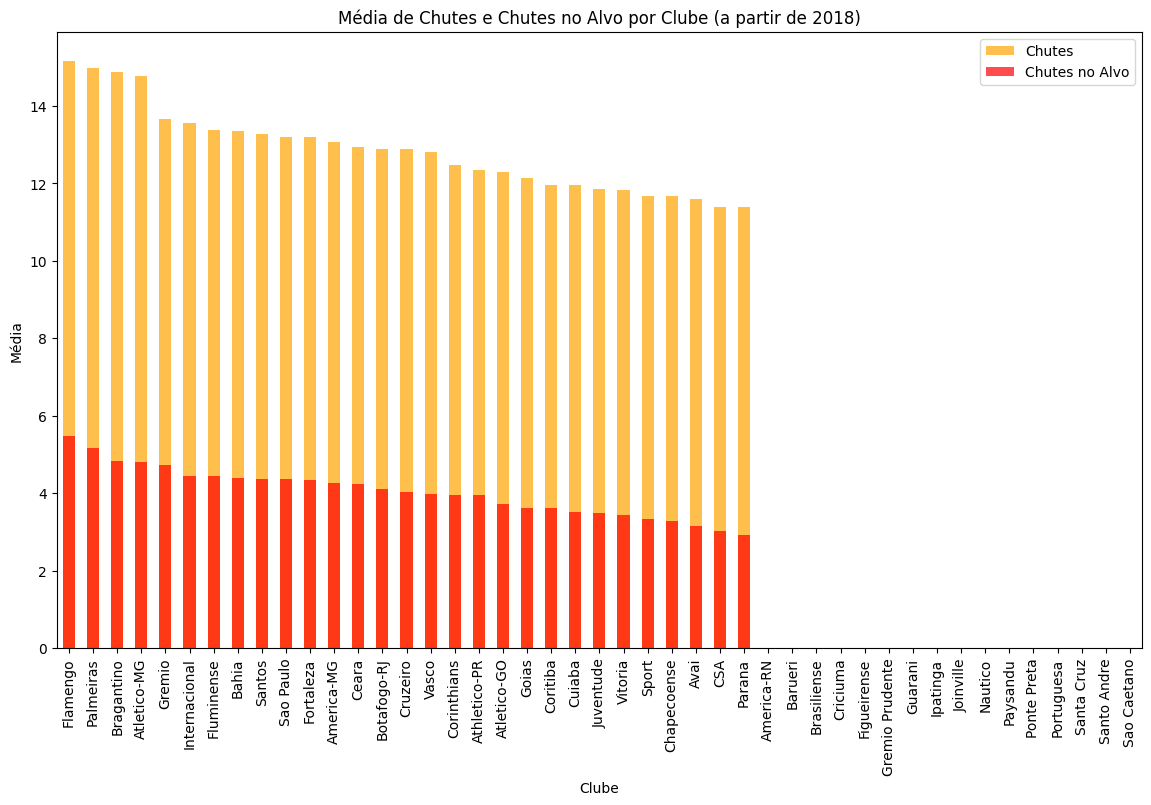

In [ ]:
# Calcular a média de chutes e chutes no alvo por clube
chutes_media_clube = df_precisao.groupby('clube')['chutes'].mean().sort_values(ascending=False)
chutes_alvo_media_clube = df_precisao.groupby('clube')['chutes_a_gol'].mean().sort_values(ascending=False)

# Plotar a média de chutes por clube
plt.figure(figsize=(14, 8))
chutes_media_clube.plot(kind='bar', color='orange', alpha=0.7, label='Chutes')
chutes_alvo_media_clube.plot(kind='bar', color='red', alpha=0.7, label='Chutes no Alvo')
plt.title('Média de Chutes e Chutes no Alvo por Clube (a partir de 2018)')
plt.xlabel('Clube')
plt.ylabel('Média')
plt.legend()
plt.show()

Interpretação Geral:

* **Ofensividade e Precisão:** Clubes com maior média de chutes e chutes no alvo tendem a ser mais ofensivos e eficientes em suas jogadas de ataque. Esses clubes são geralmente aqueles que ocupam as posições mais altas na tabela do campeonato.
* **Impacto na Performance:** A capacidade de chutar frequentemente e com precisão está diretamente correlacionada com a performance geral dos clubes. Isso sugere que estratégias focadas em aumentar a quantidade e a precisão dos chutes podem ser eficazes para melhorar os resultados das partidas.

### **Análise de Faltas e Disciplina**

#### **Número de Faltas: Comparar a média de faltas cometidas por clube (após 2015)**

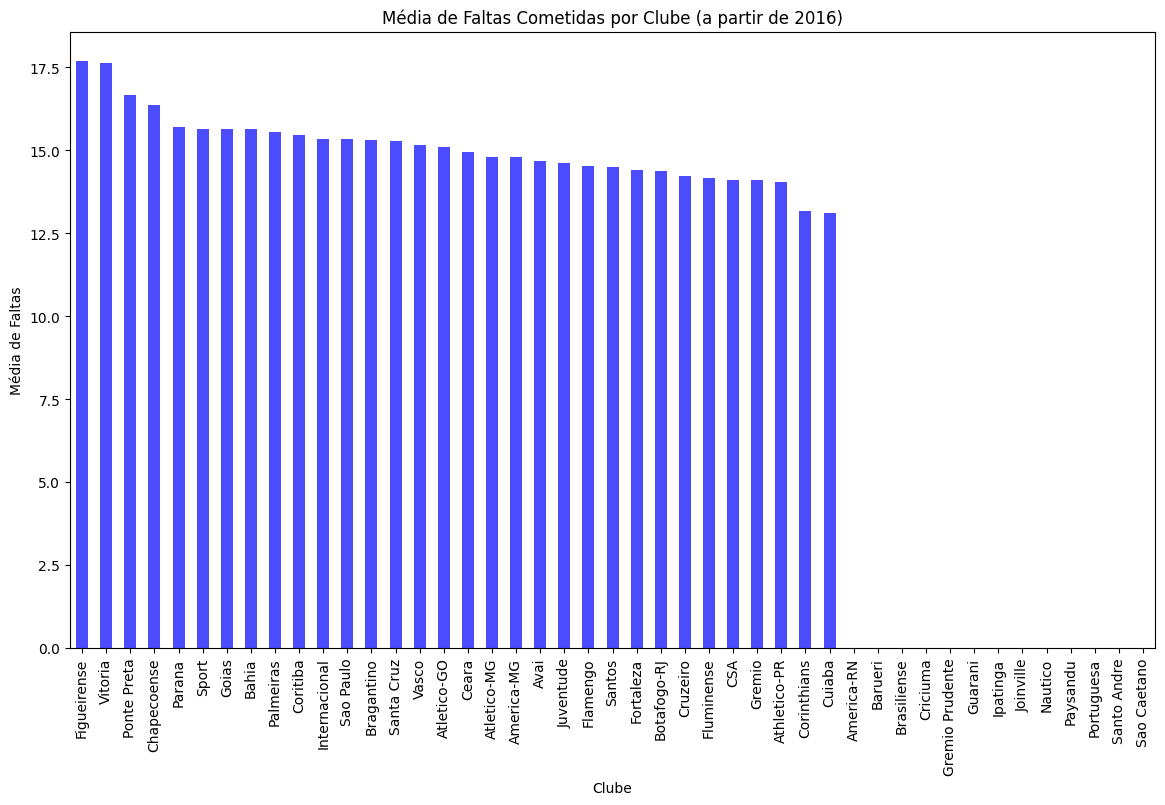

In [ ]:
# Filtrar dados a partir de 2016 para faltas
df_faltas = df_estatisticas[df_estatisticas['ano'] > 2015]

# Calcular a média de faltas por clube
faltas_media_clube = df_faltas.groupby('clube')['faltas'].mean().sort_values(ascending=False)

# Plotar a média de faltas por clube
plt.figure(figsize=(14, 8))
faltas_media_clube.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Média de Faltas Cometidas por Clube (a partir de 2016)')
plt.xlabel('Clube')
plt.ylabel('Média de Faltas')
plt.show()


A disciplina em campo é crucial para evitar penalidades e manter uma equipe completa durante a temporada. Clubes que conseguem balancear agressividade com disciplina têm mais chances de manter um desempenho consistente.

#### **Cartões Amarelos e Vermelhos: Analisar a média de cartões amarelos e vermelhos por clube (após 2015)**

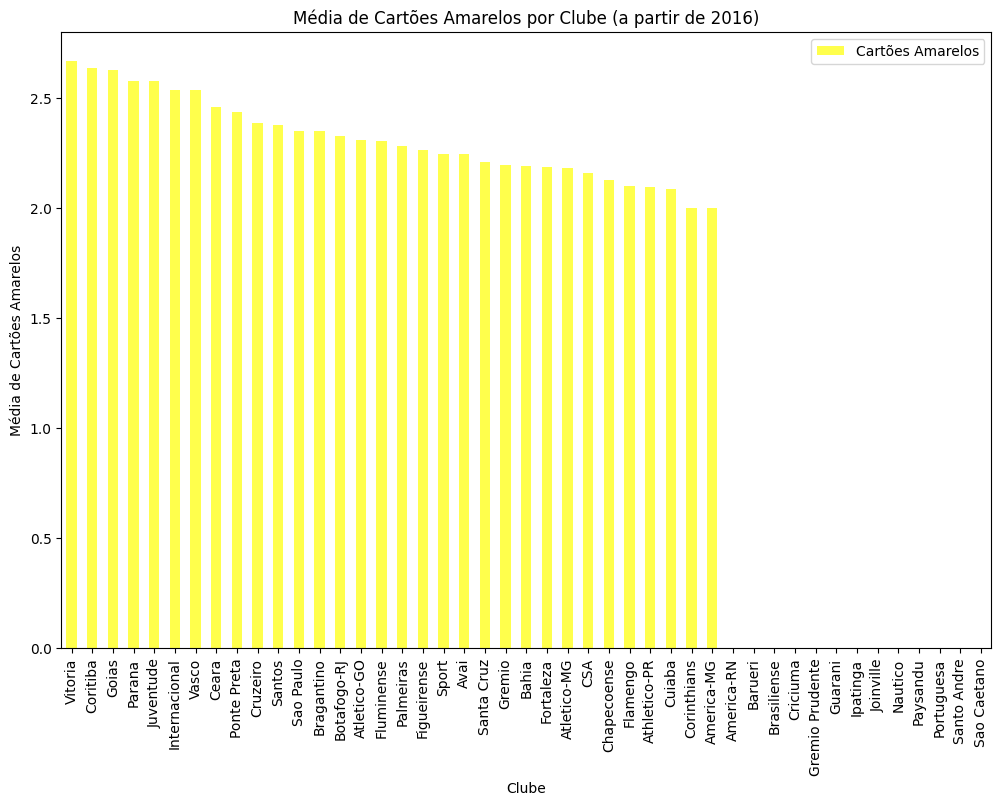

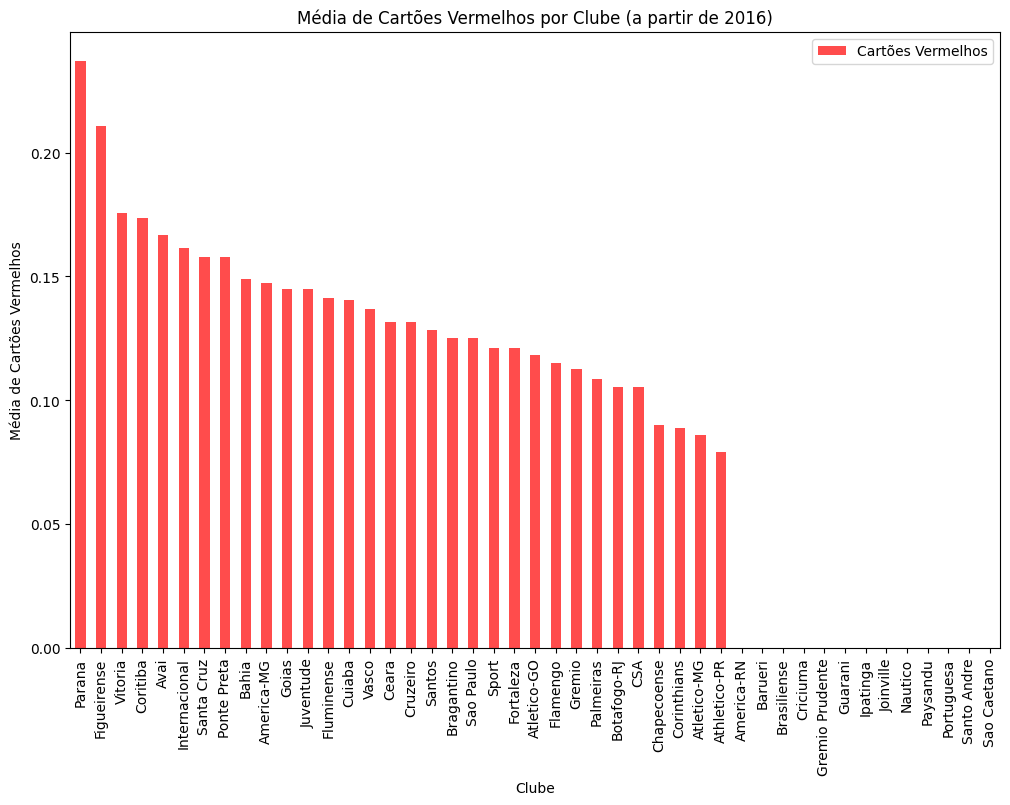

In [ ]:
# Calcular a média de cartões amarelos e vermelhos por clube
cartoes_amarelos_media_clube = df_faltas.groupby('clube')['cartao_amarelo'].mean().sort_values(ascending=False)
cartoes_vermelhos_media_clube = df_faltas.groupby('clube')['cartao_vermelho'].mean().sort_values(ascending=False)

# Plotar a média de cartões amarelos por clube
plt.figure(figsize=(12, 8))
cartoes_amarelos_media_clube.plot(kind='bar', color='yellow', alpha=0.7, label='Cartões Amarelos')
plt.title('Média de Cartões Amarelos por Clube (a partir de 2016)')
plt.xlabel('Clube')
plt.ylabel('Média de Cartões Amarelos')
plt.legend()
plt.show()

# Plotar a média de cartões vermelhos por clube
plt.figure(figsize=(12, 8))
cartoes_vermelhos_media_clube.plot(kind='bar', color='red', alpha=0.7, label='Cartões Vermelhos')
plt.title('Média de Cartões Vermelhos por Clube (a partir de 2016)')
plt.xlabel('Clube')
plt.ylabel('Média de Cartões Vermelhos')
plt.legend()
plt.show()


Receber muitos cartões pode impactar negativamente a performance dos clubes, resultando em suspensões de jogadores chave e afetando a consistência da equipe.

### **Análise de Mandantes vs Visitantes**

#### **Desempenho dos Mandantes e Visitantes**

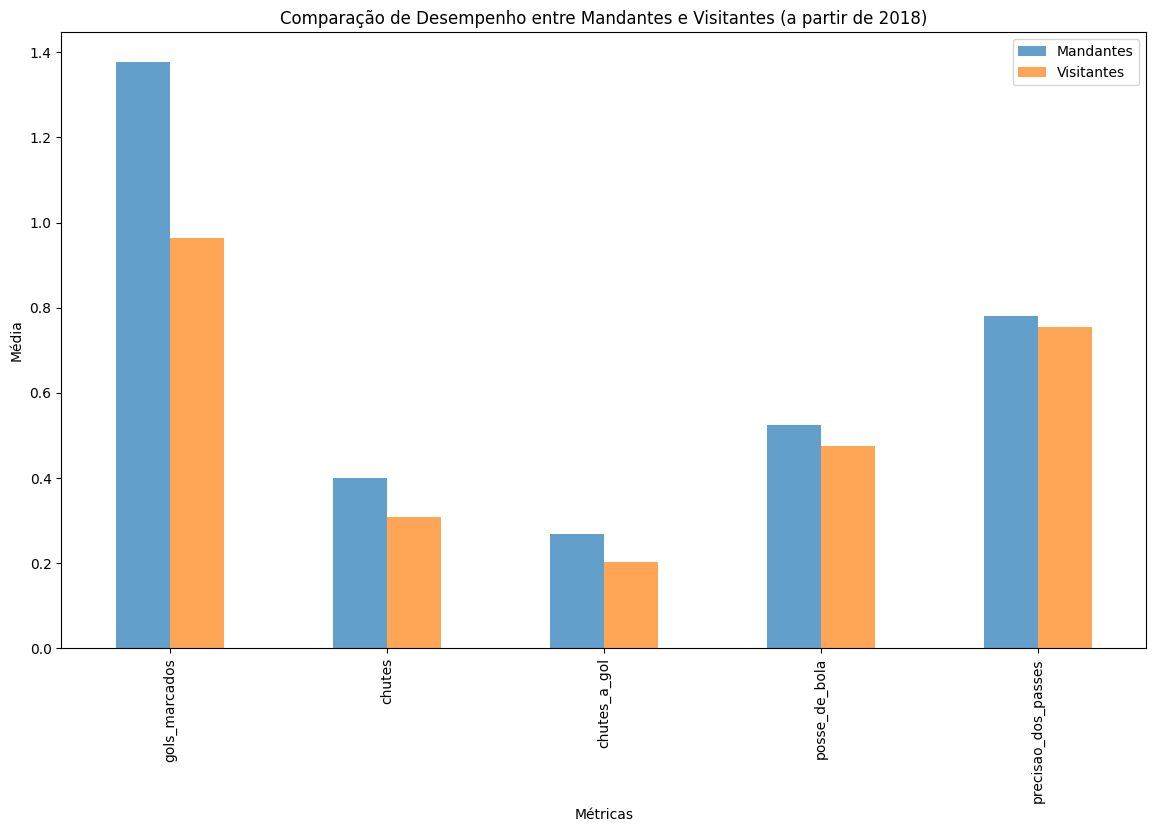

In [ ]:
# Filtrar dados a partir de 2018
df_mandantes_visitantes = df_estatisticas_minmax[df_estatisticas_minmax['ano'] > 2017]

# Calcular médias para mandantes e visitantes
metricas = ['gols_marcados', 'chutes', 'chutes_a_gol', 'posse_de_bola', 'precisao_dos_passes']
media_mandantes = df_mandantes_visitantes[df_mandantes_visitantes['mandante'] == 1][metricas].mean()
media_visitantes = df_mandantes_visitantes[df_mandantes_visitantes['mandante'] == 0][metricas].mean()

# Criar DataFrame para visualização
media_comparacao = pd.DataFrame({'Mandantes': media_mandantes, 'Visitantes': media_visitantes})

# Plotar comparações
media_comparacao.plot(kind='bar', figsize=(14, 8), alpha=0.7)
plt.title('Comparação de Desempenho entre Mandantes e Visitantes (a partir de 2018)')
plt.xlabel('Métricas')
plt.ylabel('Média')
plt.show()

#### **Vantagem de Jogo em Casa: Vitórias e Gols**

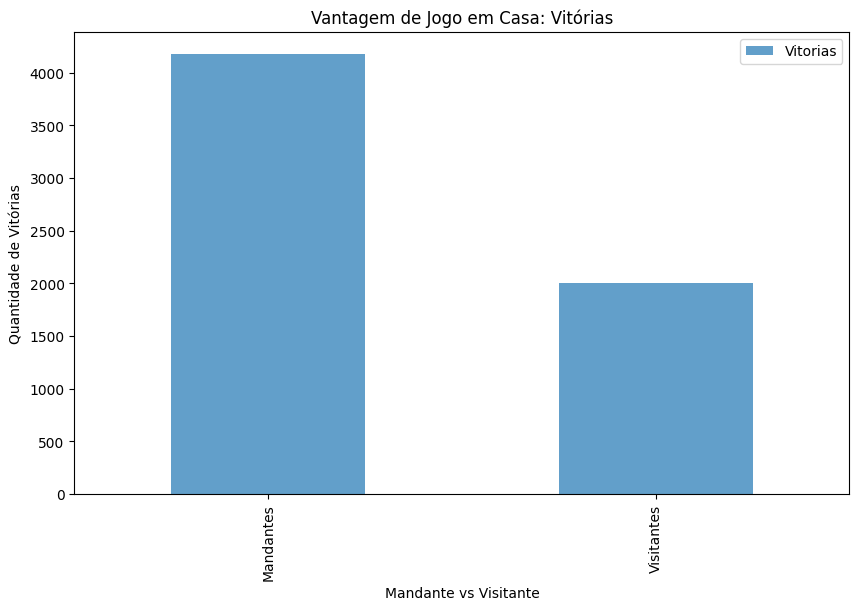

In [ ]:
# Calcular a quantidade de vitórias para mandantes e visitantes
vitorias_mandantes =  df_estatisticas[( df_estatisticas['mandante'] == 1) & (df_estatisticas['vencedor'] == 3)].shape[0]
vitorias_visitantes = df_estatisticas[(df_estatisticas['mandante'] == 0) & (df_estatisticas['vencedor'] == 3)].shape[0]

# Criar DataFrame para visualização
vantagem_casa = pd.DataFrame({
    'Vitorias': [vitorias_mandantes, vitorias_visitantes]
}, index=['Mandantes', 'Visitantes'])

# Plotar vantagem de jogo em casa
vantagem_casa.plot(kind='bar', figsize=(10, 6), alpha=0.7)
plt.title('Vantagem de Jogo em Casa: Vitórias')
plt.xlabel('Mandante vs Visitante')
plt.ylabel('Quantidade de Vitórias')
plt.show()


### **Quantidade de gols por temporada:**

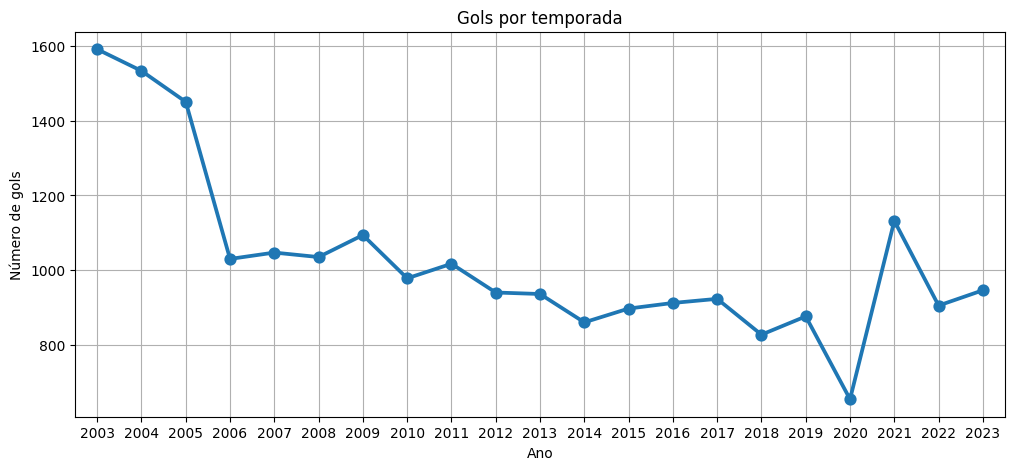

In [ ]:
saldo_gols = df_estatisticas.groupby('ano')["gols_marcados"].sum().reset_index()
saldo_gols = saldo_gols.sort_values(by="gols_marcados", ascending=False)

# Visualizar a quantidade de gols por temporada
plt.figure(figsize=(12,5))
sns.pointplot(x="ano", y="gols_marcados", data=saldo_gols)
plt.title("Gols por temporada")
plt.xlabel("Ano")
plt.ylabel("Número de gols")
plt.grid(True)
plt.show()

Observa-se uma tendência geral de declínio na quantidade de gols marcados ao longo das temporadas, com exceção de algumas variações. Devido a interrupções e mudanças no calendário por conta da pandemia de COVID-19 é possivel nota que existe uma anomalia nessa tendência nos anos de 2020 e 2021.

### **Correlação entre variáveis:**

Como os dados até 2018 não tem as informações completas que podemos analisar melhor uma correlação entre as colunas (como posse de bola e precisão de passes). Vamos apenas considerar os dados a partir de 2018.

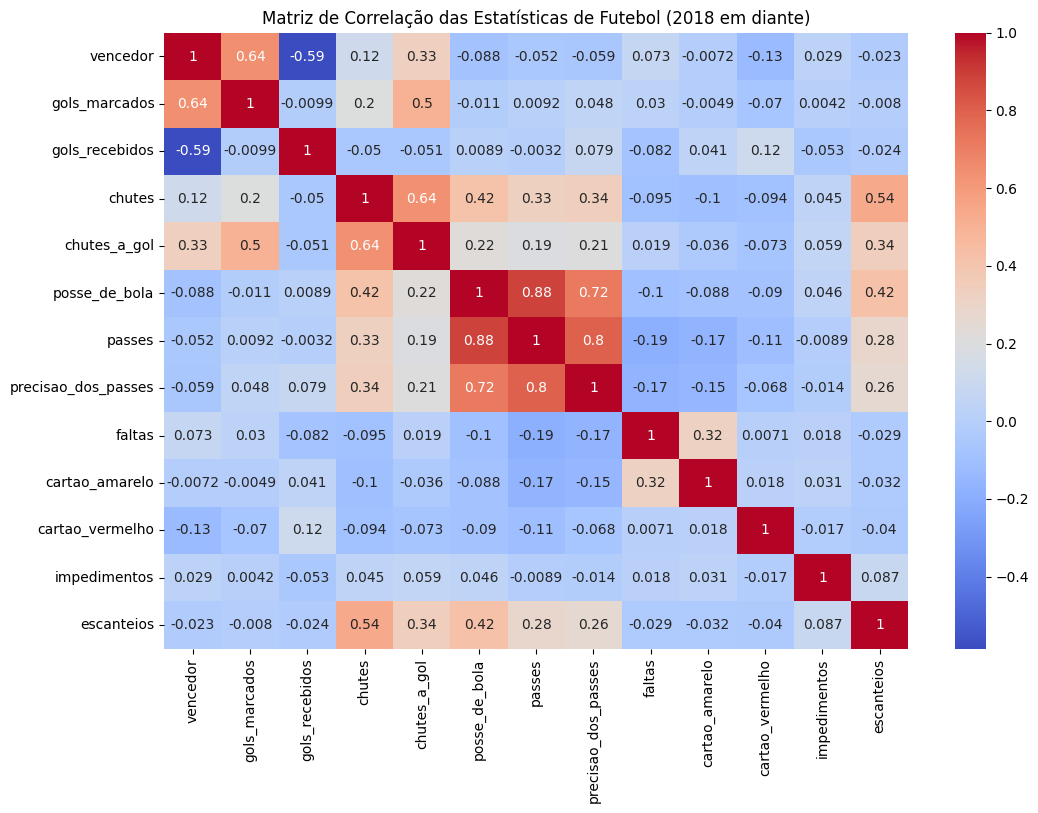

In [ ]:
# Selecionar apenas as colunas desejadas
colunas_selecionadas = ['vencedor','gols_marcados', 'gols_recebidos', 'chutes', 'chutes_a_gol',
                        'posse_de_bola', 'passes', 'precisao_dos_passes', 'faltas',
                        'cartao_amarelo', 'cartao_vermelho', 'impedimentos', 'escanteios']

# Calcular a matriz de correlação
correlation_matrix = df_estatisticas[df_estatisticas['ano'] > 2017][colunas_selecionadas].corr()

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação das Estatísticas de Futebol (2018 em diante)')
plt.show()

**Análise geral do heatmap:**
1. Efetividade Ofensiva:

* Gols Marcados e Vitórias: Forte correlação positiva (0.643). Equipes que marcam mais gols tendem a vencer mais jogos.
* Chutes a Gol e Vitórias: Correlação moderada positiva (0.335). A precisão nos chutes a gol é crucial para a vitória.

2. Defesa Eficiente:

* Gols Recebidos e Vitórias: Correlação negativa moderada (-0.586). Como era de se esperar sofrer menos gols está associado a mais vitórias.

3. Controle de Bola:

* Posse de Bola e Passes: Forte correlação positiva (0.885). Equipes com maior posse de bola realizam mais passes.
* Posse de Bola e Precisão dos Passes: Correlação positiva forte (0.715). Maior posse de bola está ligada a uma maior precisão nos passes.
4. Disciplina:

* Faltas e Cartões Amarelos: Correlação positiva (0.323). Mais faltas resultam em mais cartões amarelos.
* Cartões Vermelhos e Vitórias: Correlação negativa (-0.131). Receber mais cartões vermelhos está associado a menos vitórias.


**Análise das condições de vitória:**

A análise das correlações com a vitória revela que marcar gols é o fator mais fortemente associado à vitória, seguido pela importância de sofrer menos gols, indicando a necessidade de uma defesa sólida. Ter mais chutes a gol também aumenta significativamente as chances de vitória, enquanto a quantidade total de chutes tem uma influência menor. Surpreendentemente, a posse de bola e o número de passes têm correlações muito fracas com a vitória, sugerindo que controlar a bola por mais tempo não garante vitórias. A precisão dos passes também não é um fator determinante isolado. Cometer faltas tem uma correlação positiva muito fraca com a vitória, e receber cartões amarelos tem uma correlação negativa insignificante, indicando que a indisciplina leve não afeta fortemente os resultados dos jogos. Receber cartões vermelhos, por outro lado, tem uma correlação negativa moderada com a vitória, destacando a importância de evitar expulsões. A quantidade de escanteios e os impedimentos têm correlações muito fracas com a vitória, sugerindo que essas métricas não são decisivas para o sucesso

## **Teste de Hipótese:**

Podemos focar em algumas comparações chave, como verificar se há uma diferença significativa entre mandantes e visitantes em termos de vitórias, posse de bola, precisão de passes, etc.

1. Teste de Hipótese: Vitórias de Mandantes vs Visitantes
* Hipótese Nula (H0): Não há diferença significativa entre a quantidade de vitórias dos mandantes e visitantes.

* Hipótese Alternativa (H1): Há uma diferença significativa entre a quantidade de vitórias dos mandantes e visitantes.

2. Teste de Hipótese: Posse de Bola de Mandantes vs Visitantes
* Hipótese Nula (H0): Não há diferença significativa na posse de bola entre mandantes e visitantes.

* Hipótese Alternativa (H1): Há uma diferença significativa na posse de bola entre mandantes e visitantes.

3. Teste de Hipótese: Precisão de Passes de Mandantes vs Visitantes
* Hipótese Nula (H0): Não há diferença significativa na precisão de passes entre mandantes e visitantes.

* Hipótese Alternativa (H1): Há uma diferença significativa na precisão de passes entre mandantes e visitantes.

4. Teste de Hipótese: Média de Gols de Mandantes vs Visitantes
* Hipótese Nula (H0): Não há diferença significativa na média de gols entre mandantes e visitantes.

* Hipótese Alternativa (H1): Há uma diferença significativa na média de gols entre mandantes e visitantes.

Vamos começar com a execução dos testes de hipóteses usando o teste t para amostras independentes.

In [ ]:
# Filtrar dados a partir de 2018
df_filtrado = df_estatisticas[df_estatisticas['ano'] > 2017]

# Separar dados de mandantes e visitantes
mandantes = df_filtrado[df_filtrado['mandante'] == 1]
visitantes = df_filtrado[df_filtrado['mandante'] == 0]

# Função para realizar teste t e imprimir resultado
def teste_hipotese(metrica, alfa=0.05):
    t_stat, p_value = ttest_ind(mandantes[metrica], visitantes[metrica], equal_var=False)
    print(f'Teste de Hipótese para {metrica}:')
    print(f'Estatística t: {t_stat:.4f}, Valor p: {p_value:.4f}')
    if p_value < alfa:
        print(f'Rejeitamos a Hipótese Nula. Há diferença significativa na métrica {metrica} entre mandantes e visitantes.\n')
    else:
        print(f'Não rejeitamos a Hipótese Nula. Não há diferença significativa na métrica {metrica} entre mandantes e visitantes.\n')

# Realizar os testes de hipóteses para cada métrica
metricas = ['vencedor', 'posse_de_bola', 'precisao_dos_passes', 'gols_marcados']
for metrica in metricas:
    teste_hipotese(metrica)

Teste de Hipótese para vencedor:
Estatística t: 18.0924, Valor p: 0.0000
Rejeitamos a Hipótese Nula. Há diferença significativa na métrica vencedor entre mandantes e visitantes.

Teste de Hipótese para posse_de_bola:
Estatística t: 8.8474, Valor p: 0.0000
Rejeitamos a Hipótese Nula. Há diferença significativa na métrica posse_de_bola entre mandantes e visitantes.

Teste de Hipótese para precisao_dos_passes:
Estatística t: 7.9356, Valor p: 0.0000
Rejeitamos a Hipótese Nula. Há diferença significativa na métrica precisao_dos_passes entre mandantes e visitantes.

Teste de Hipótese para gols_marcados:
Estatística t: 13.0565, Valor p: 0.0000
Rejeitamos a Hipótese Nula. Há diferença significativa na métrica gols_marcados entre mandantes e visitantes.



Os resultados dos testes de hipóteses indicam que o fator "jogar em casa" confere uma vantagem significativa aos times mandantes em diversas métricas de desempenho. Especificamente, os mandantes têm mais vitórias, maior posse de bola, melhor precisão nos passes e marcam mais gols em comparação aos visitantes. Isso reforça a ideia de que jogar em casa proporciona um benefício notável aos times em várias dimensões do jogo.